<a href="https://colab.research.google.com/github/Rachhh53/House-Prices-Advanced-Regression-Techniques-Kaggle/blob/main/house_prices_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingest

In [1]:
pip install dython

In [2]:
pip install pwlf

  Created wheel for pwlf: filename=pwlf-2.0.5-py3-none-any.whl size=16258 sha256=22b37166d708246e0cc7abacf16f523c3354488d2fcef35ab99f6d54b92e7141
  Stored in directory: /root/.cache/pip/wheels/45/2f/fc/b6fa783a4c39252e6fca24c9bdd4df50bfc0771cba3a83063c
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=be078ad242f2b20cb6d692567ef7bd8bcd959344ffd7c1669b4231e66edeeb9c
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pwlf pyDOE


The dependent variable of interest is house prices in Ames, Iowa (‘SalePrice’). 

In [3]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from dython.nominal import associations
import statsmodels.api as sm
from google.colab import files
import pwlf
from scipy import optimize

# Figures inline and set visualization style
%matplotlib inline
sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Import test and train datasets
df_train = pd.read_csv('https://raw.githubusercontent.com/Rachhh53/House-Prices-Advanced-Regression-Techniques-Kaggle/main/train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Rachhh53/House-Prices-Advanced-Regression-Techniques-Kaggle/main/test.csv')

# View first lines of training data
df_train.head(n=4)

Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000

[4 rows x 81 columns]

In [5]:
# View first lines of test data
df_test.head()

Id  MSSubClass MSZoning  ...  YrSold  SaleType SaleCondition
0  1461          20       RH  ...    2010        WD        Normal
1  1462          20       RL  ...    2010        WD        Normal
2  1463          60       RL  ...    2010        WD        Normal
3  1464          60       RL  ...    2010        WD        Normal
4  1465         120       RL  ...    2010        WD        Normal

[5 rows x 80 columns]

SalesPrice is omitted since it is our dependent variable.

In [6]:
print(f'Training Data shape: {df_train.shape} \n Test Data shape: {df_test.shape}')

Training Data shape: (1460, 81) 
 Test Data shape: (1459, 80)


In [7]:
# view data types and mission values on the training data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# EDA

<span style="color:blue">Observations:</span><br>
LotFrontage has <strong>259</strong> (1460-1201) missing values. <br>
Alley has <strong>1369</strong> (1460-91) missing values.<br>
MasVnrType has <strong>8</strong> (1460-1452) missing values.<br>
MasVnrArea has <strong>8</strong> (1460-1452) missing values.<br>
BsmtQual has <strong>37</strong> (1460-1423) missing values.<br>
BsmtCond has <strong>37</strong> (1460-1423) missing values.<br>
BsmtExposure has <strong>38</strong> (1460-1422) missing values.<br>
BsmtFinType1 has <strong>37</strong> (1460-1423) missing values.<br>
BsmtFinType2 has <strong>38</strong> (1460-1422) missing values.<br>
Electrical has <strong>1</strong> (1460-1459) missing value.<br>
FireplaceQu has <strong>690</strong> (1460-770) missing values.<br>
GarageType has <strong>81</strong> (1460-1379) missing values.<br>
GarageYrBlt has <strong>81</strong> (1460-1379) missing values.<br>
GarageFinish has <strong>81</strong> (1460-1379) missing values.<br>
GarageQual has <strong>81</strong> (1460-1379) missing values.<br>
GarageCond has <strong>81</strong> (1460-1379) missing values.<br>
PoolQC has <strong>1453</strong> (1460-7) missing values.<br>
Fence has <strong>1179</strong> (1460-281) missing values.<br>
MiscFeature has <strong>1406</strong> (1460-54) missing values.<br>

In [8]:
# credit: https://www.kaggle.com/gorkembakir/hp-eda
def plot_hist(variable):
    plt.figure(figsize=(7,3))
    plt.hist(df_train[variable],bins=30)
    plt.xlabel(variable)
    plt.title("{}".format(variable))
    plt.show()

In [9]:
#divide columns in categorical and numerical ones to have a better overview
cat_columns = df_train.select_dtypes(include=['object']).columns.tolist()
num_columns = df_train.select_dtypes(exclude=['object']).columns.tolist()
print(f'Categorical columns: \n {cat_columns} \n Numerical columns: \n {num_columns}')

Categorical columns: 
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'] 
 Numerical columns: 
 ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars'

In [10]:
df_train_cat = df_train.select_dtypes(include='object')
df_train_cat['SalePrice'] = df_train.loc[:,'SalePrice']
df_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 44 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   Alley          91 non-null     object
 3   LotShape       1460 non-null   object
 4   LandContour    1460 non-null   object
 5   Utilities      1460 non-null   object
 6   LotConfig      1460 non-null   object
 7   LandSlope      1460 non-null   object
 8   Neighborhood   1460 non-null   object
 9   Condition1     1460 non-null   object
 10  Condition2     1460 non-null   object
 11  BldgType       1460 non-null   object
 12  HouseStyle     1460 non-null   object
 13  RoofStyle      1460 non-null   object
 14  RoofMatl       1460 non-null   object
 15  Exterior1st    1460 non-null   object
 16  Exterior2nd    1460 non-null   object
 17  MasVnrType     1452 non-null   object
 18  ExterQual      1460 non-null

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


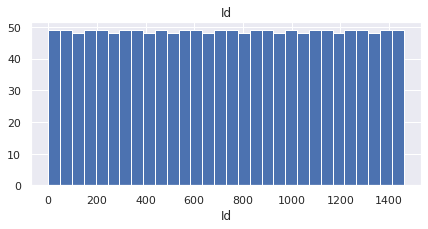

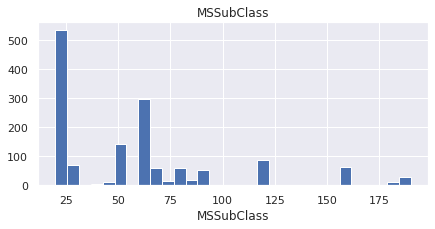

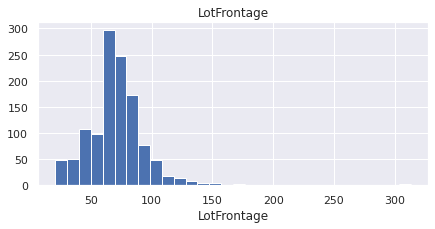

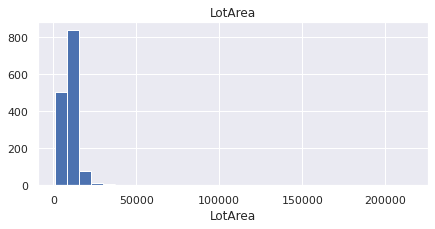

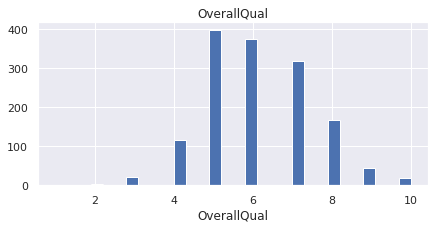

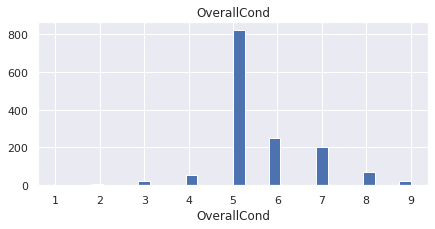

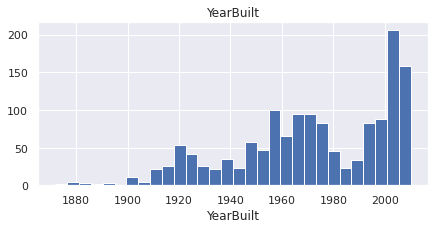

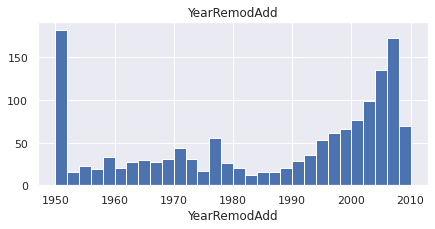

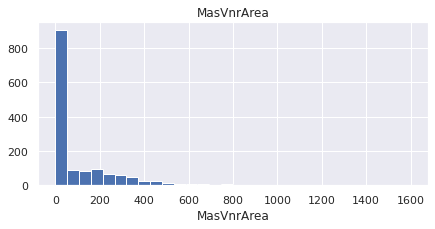

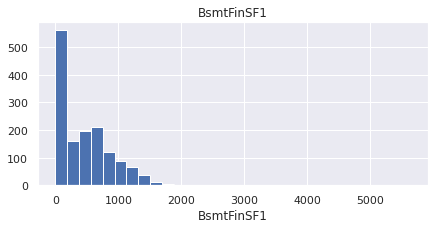

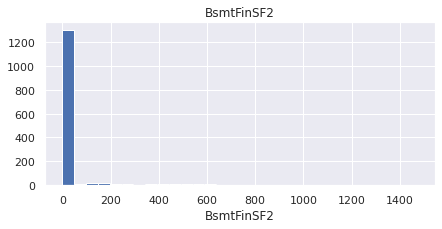

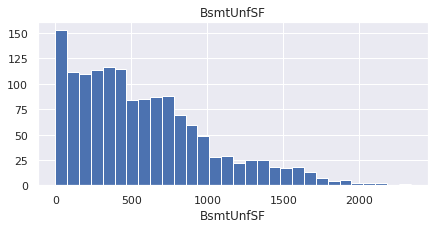

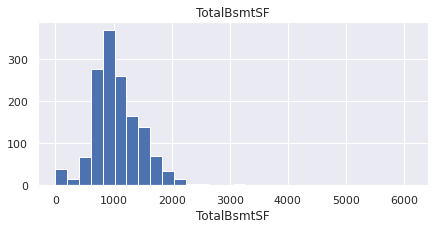

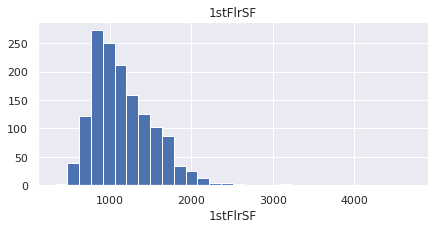

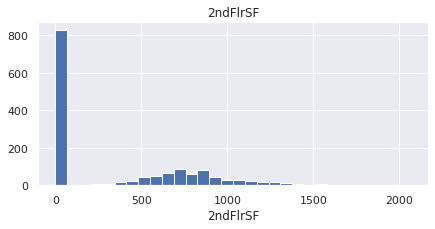

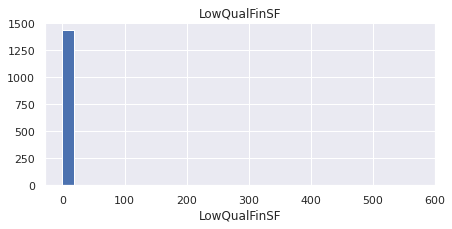

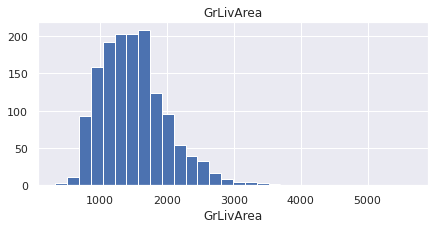

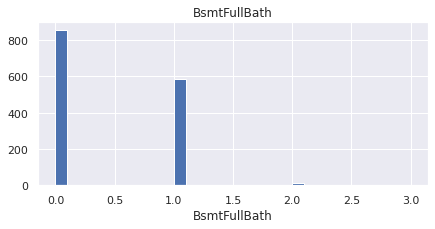

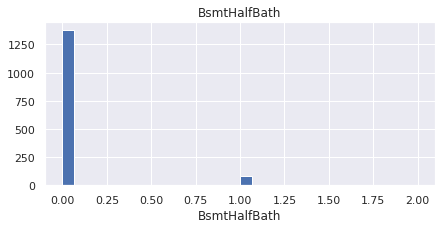

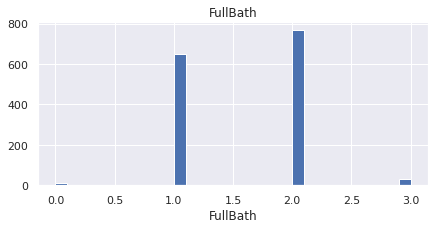

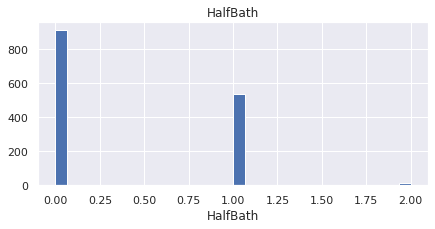

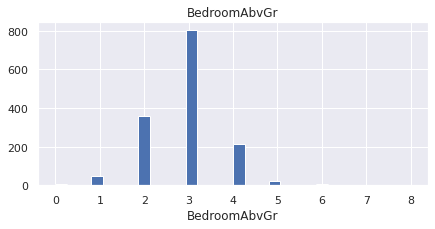

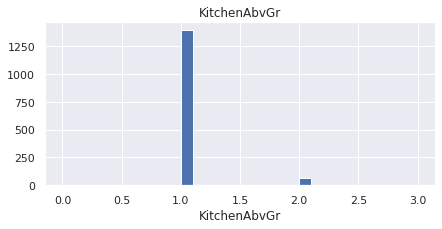

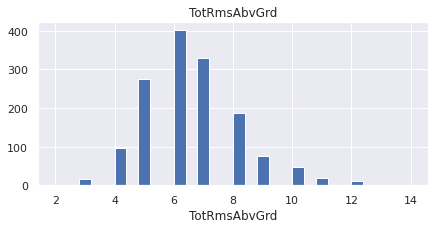

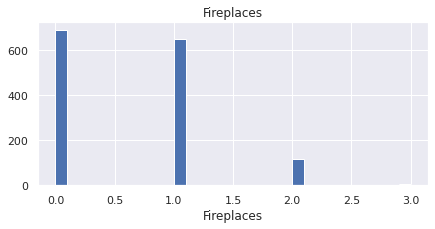

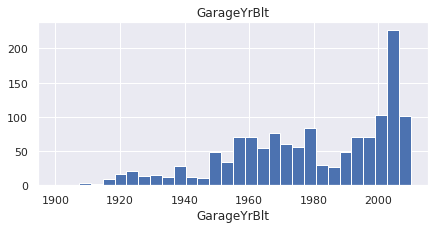

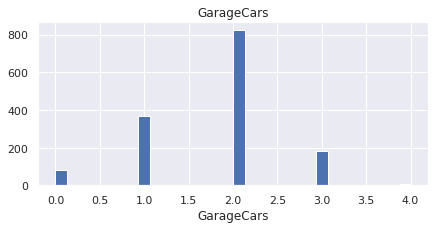

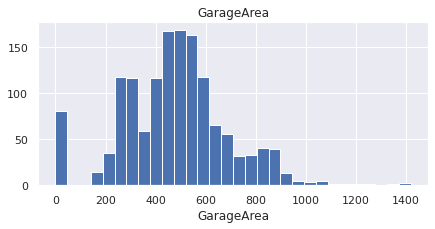

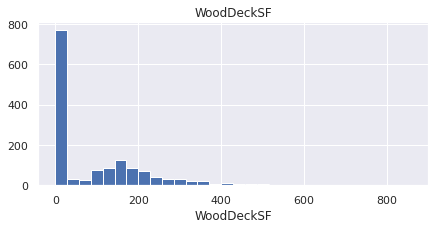

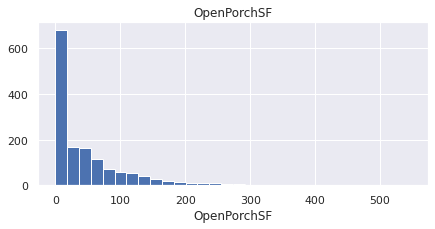

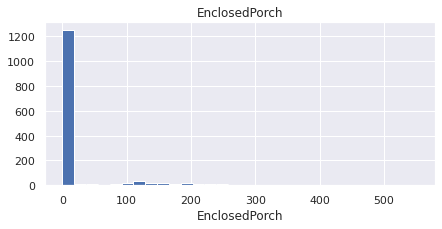

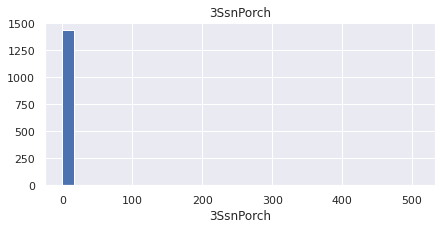

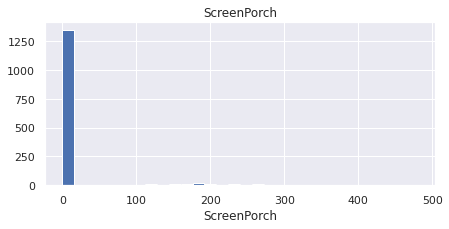

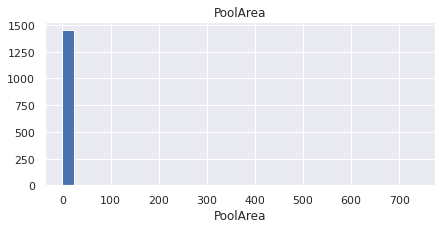

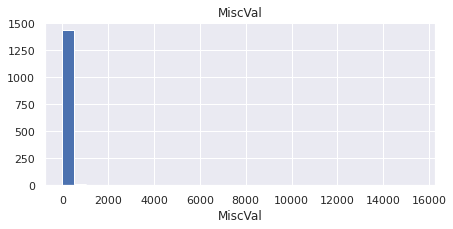

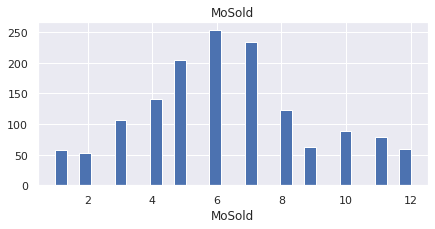

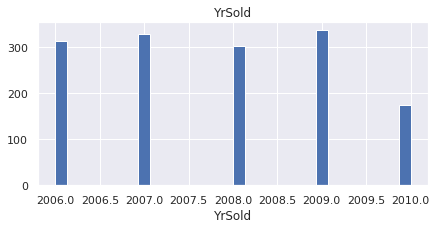

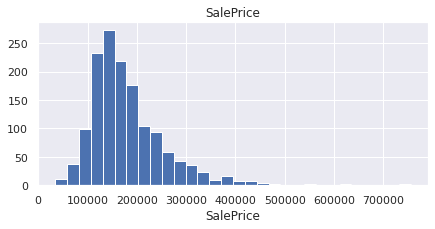

In [11]:
for n in num_columns:
    plot_hist(n)

<h3>1. Provide appropriate descriptive statistics and visualizations to help understand the marginal distribution of the dependent variable.</h3>

In [12]:
df_train.describe()

Id   MSSubClass  ...       YrSold      SalePrice
count  1460.000000  1460.000000  ...  1460.000000    1460.000000
mean    730.500000    56.897260  ...  2007.815753  180921.195890
std     421.610009    42.300571  ...     1.328095   79442.502883
min       1.000000    20.000000  ...  2006.000000   34900.000000
25%     365.750000    20.000000  ...  2007.000000  129975.000000
50%     730.500000    50.000000  ...  2008.000000  163000.000000
75%    1095.250000    70.000000  ...  2009.000000  214000.000000
max    1460.000000   190.000000  ...  2010.000000  755000.000000

[8 rows x 38 columns]

<h4>A linear regression fit and univariate KDE curves.</h4>

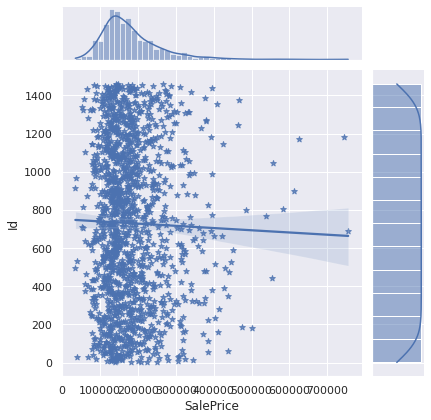

In [13]:
# here "*" is used as a marker for scatterplot
sns.jointplot(data=df_train, x="SalePrice", y="Id", kind="reg", marker="*")

I used Id as the y-axis to ensure I saw all data about SalePrice without noise.<br>
<span style="color:blue">Observations:</span><br>
It looks like there are a few outliers at the highest sale price, leading to a long right tail, but the distibution is mostly normal for SalePrice.

<h3>2. Investigate missing data and outliers.</h3>

<h4>Missing Data</h4>

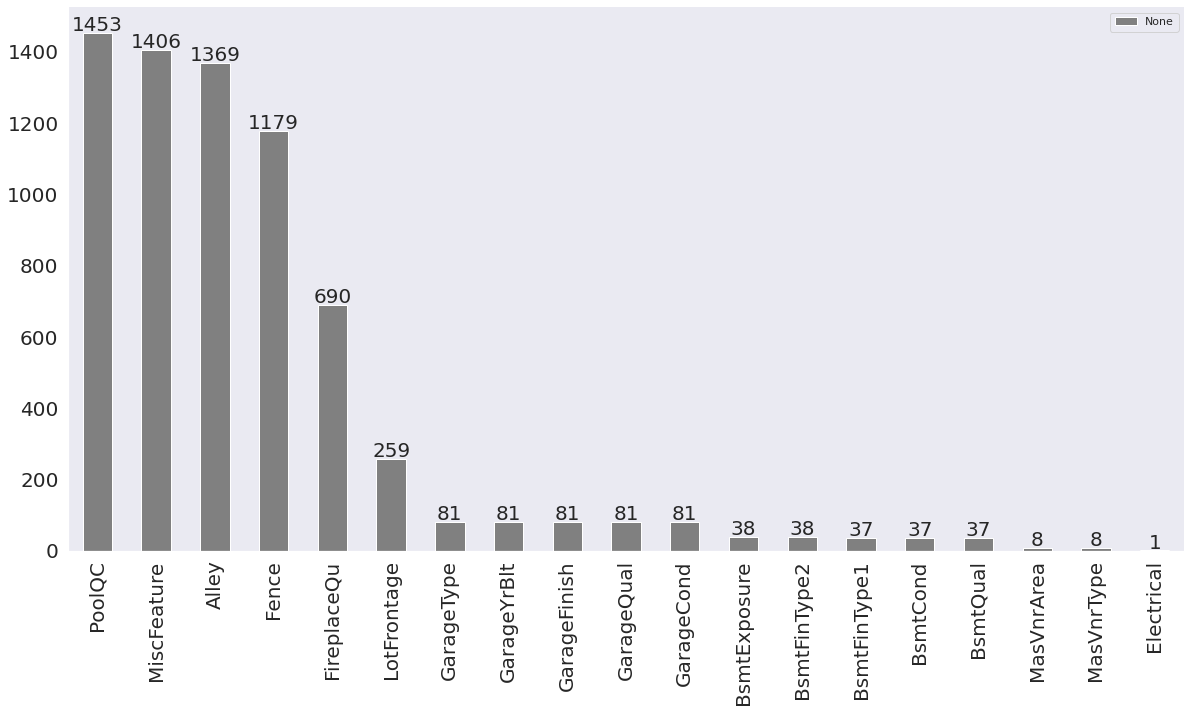

In [14]:
# credit: https://www.kaggle.com/ohseokkim/house-price-all-about-house-price
# .loc[:, ] sets a value for an entire column
isnull_series = df_train.loc[:,:'SaleCondition'].isnull().sum()
isnull_series[isnull_series > 0].sort_values(ascending=False)

plt.figure(figsize = (20,10))
ax = isnull_series[isnull_series > 0].sort_values(ascending=False).plot(kind='bar',
                                                                        grid = False,
                                                                        fontsize=20,
                                                                        color='grey')
plt.legend(loc = 'upper right')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width() / 2., height + 5, height, ha = 'center', size = 20)
sns.despine()

All the above features have missing data.

<h4>Outliers</h4>

In [15]:
def get_boxplots(feat):
    plt.figure()
    return sns.boxplot(x=df_train[feat])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


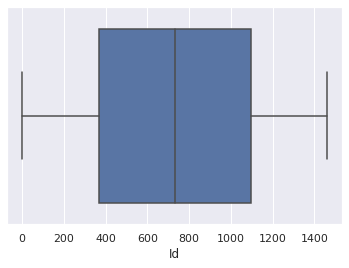

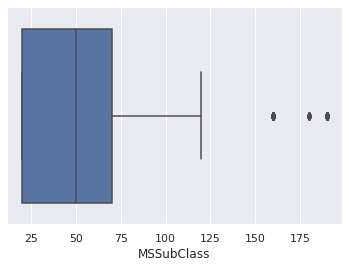

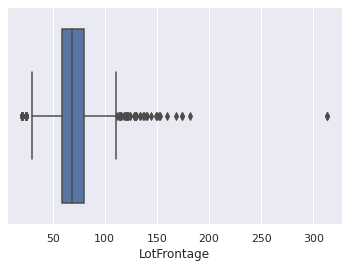

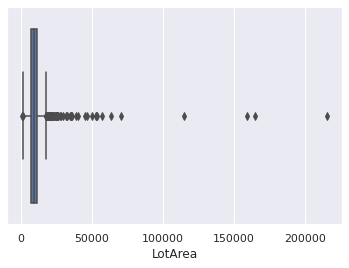

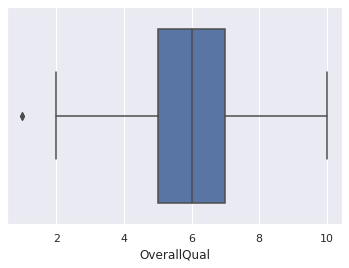

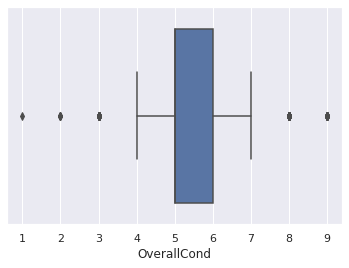

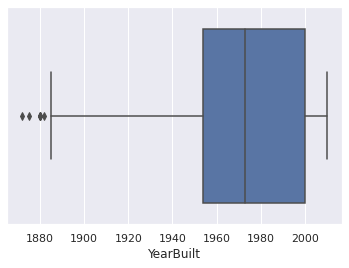

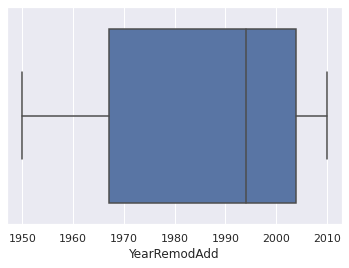

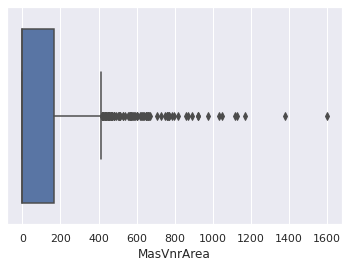

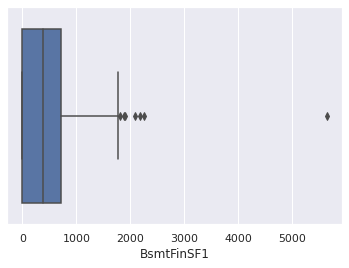

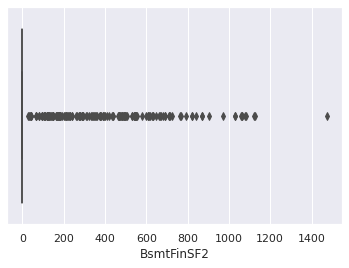

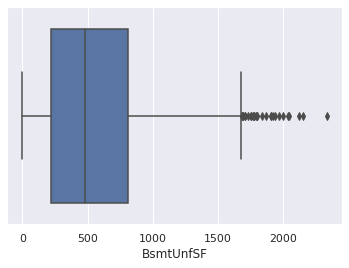

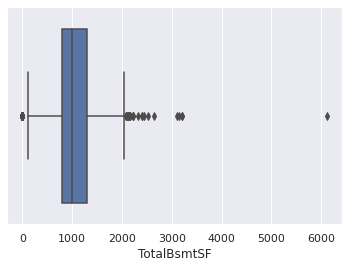

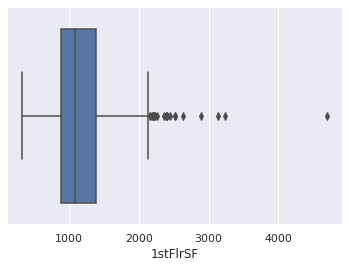

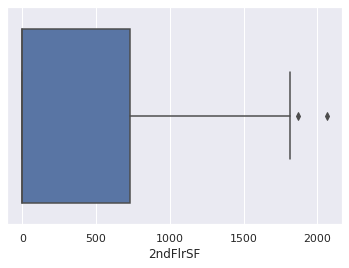

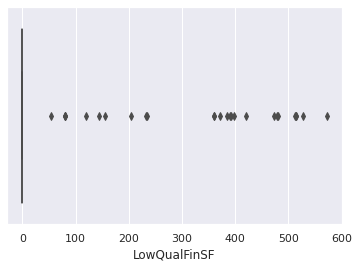

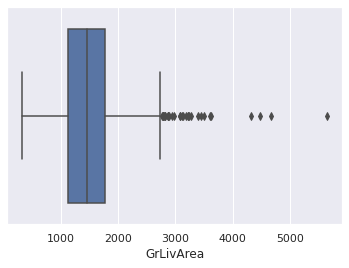

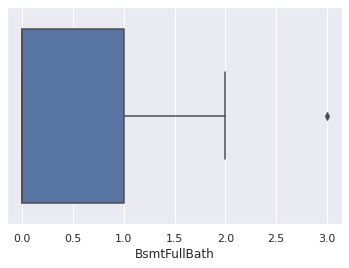

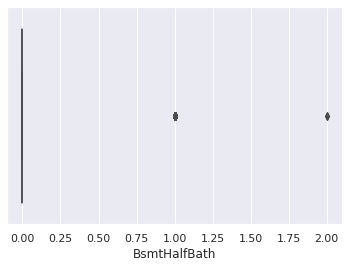

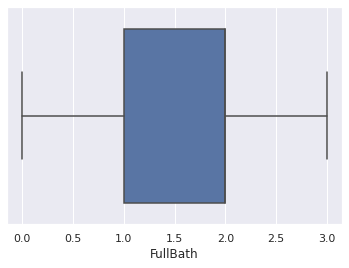

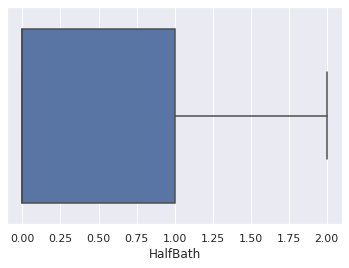

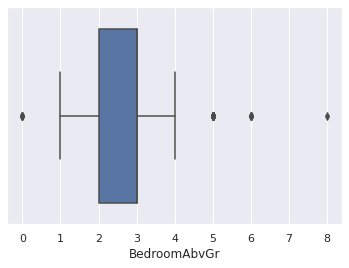

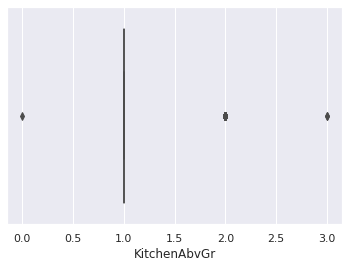

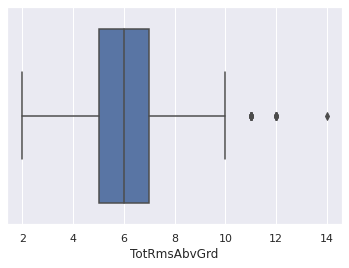

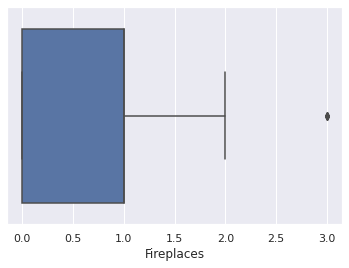

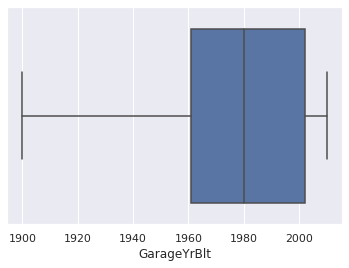

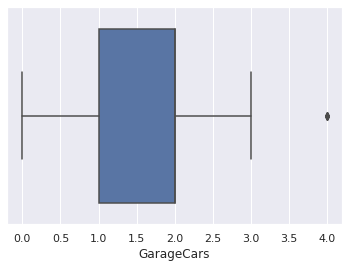

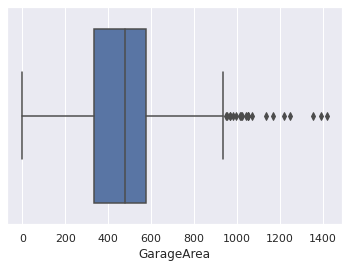

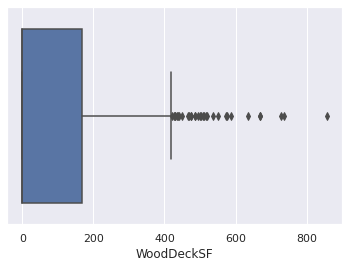

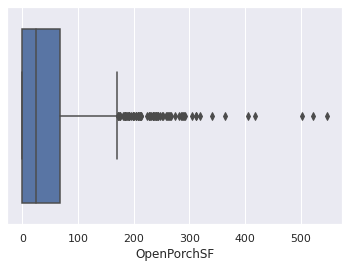

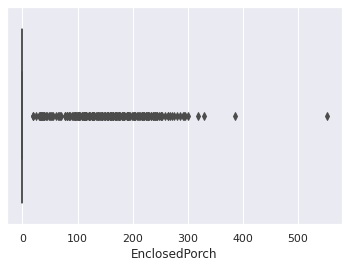

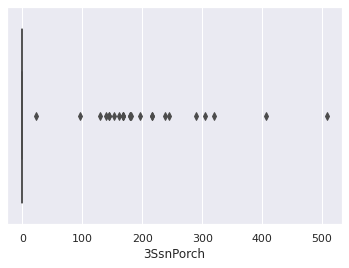

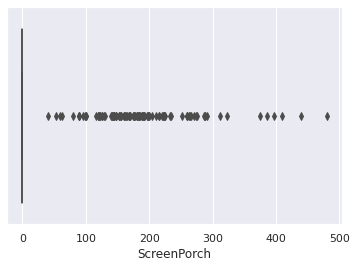

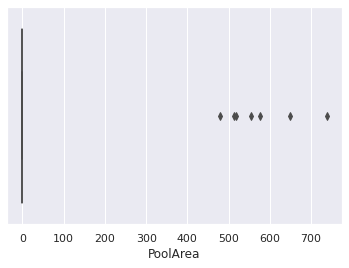

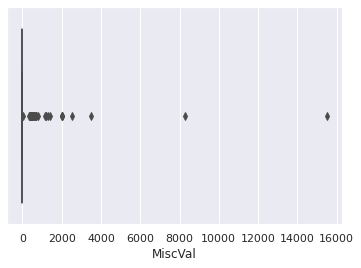

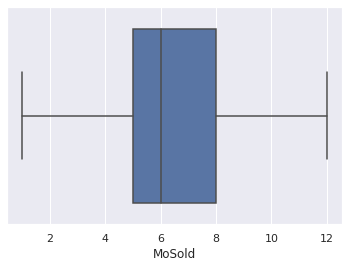

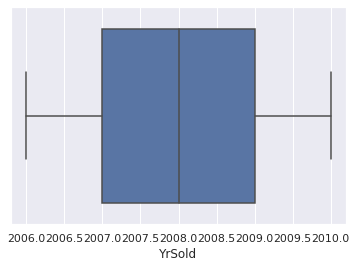

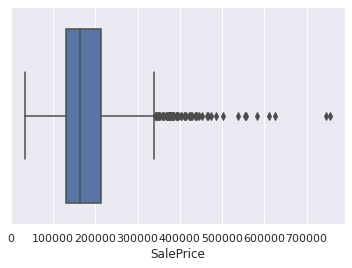

In [16]:
# boxplots to identify outliers
for f in num_columns:
    get_boxplots(f)

<span style="color:blue">Observations:</span><br>
Almost all of our features have an outlier or two. Some of our features do not follow a normal distribution and appear as entirely outliers.<br>
For example: An obvious feature to see an outlier is in KitchenAvbGr. Most would expect that homes have a kitchen on the ground floor. A home with 0, 2 or 3 kitchens on the ground floor has been flagged as an outlier.

<h3>3. Investigate at least three potential predictors of the dependent variable and provide appropriate graphs / statistics to demonstrate the relationships.</h3>

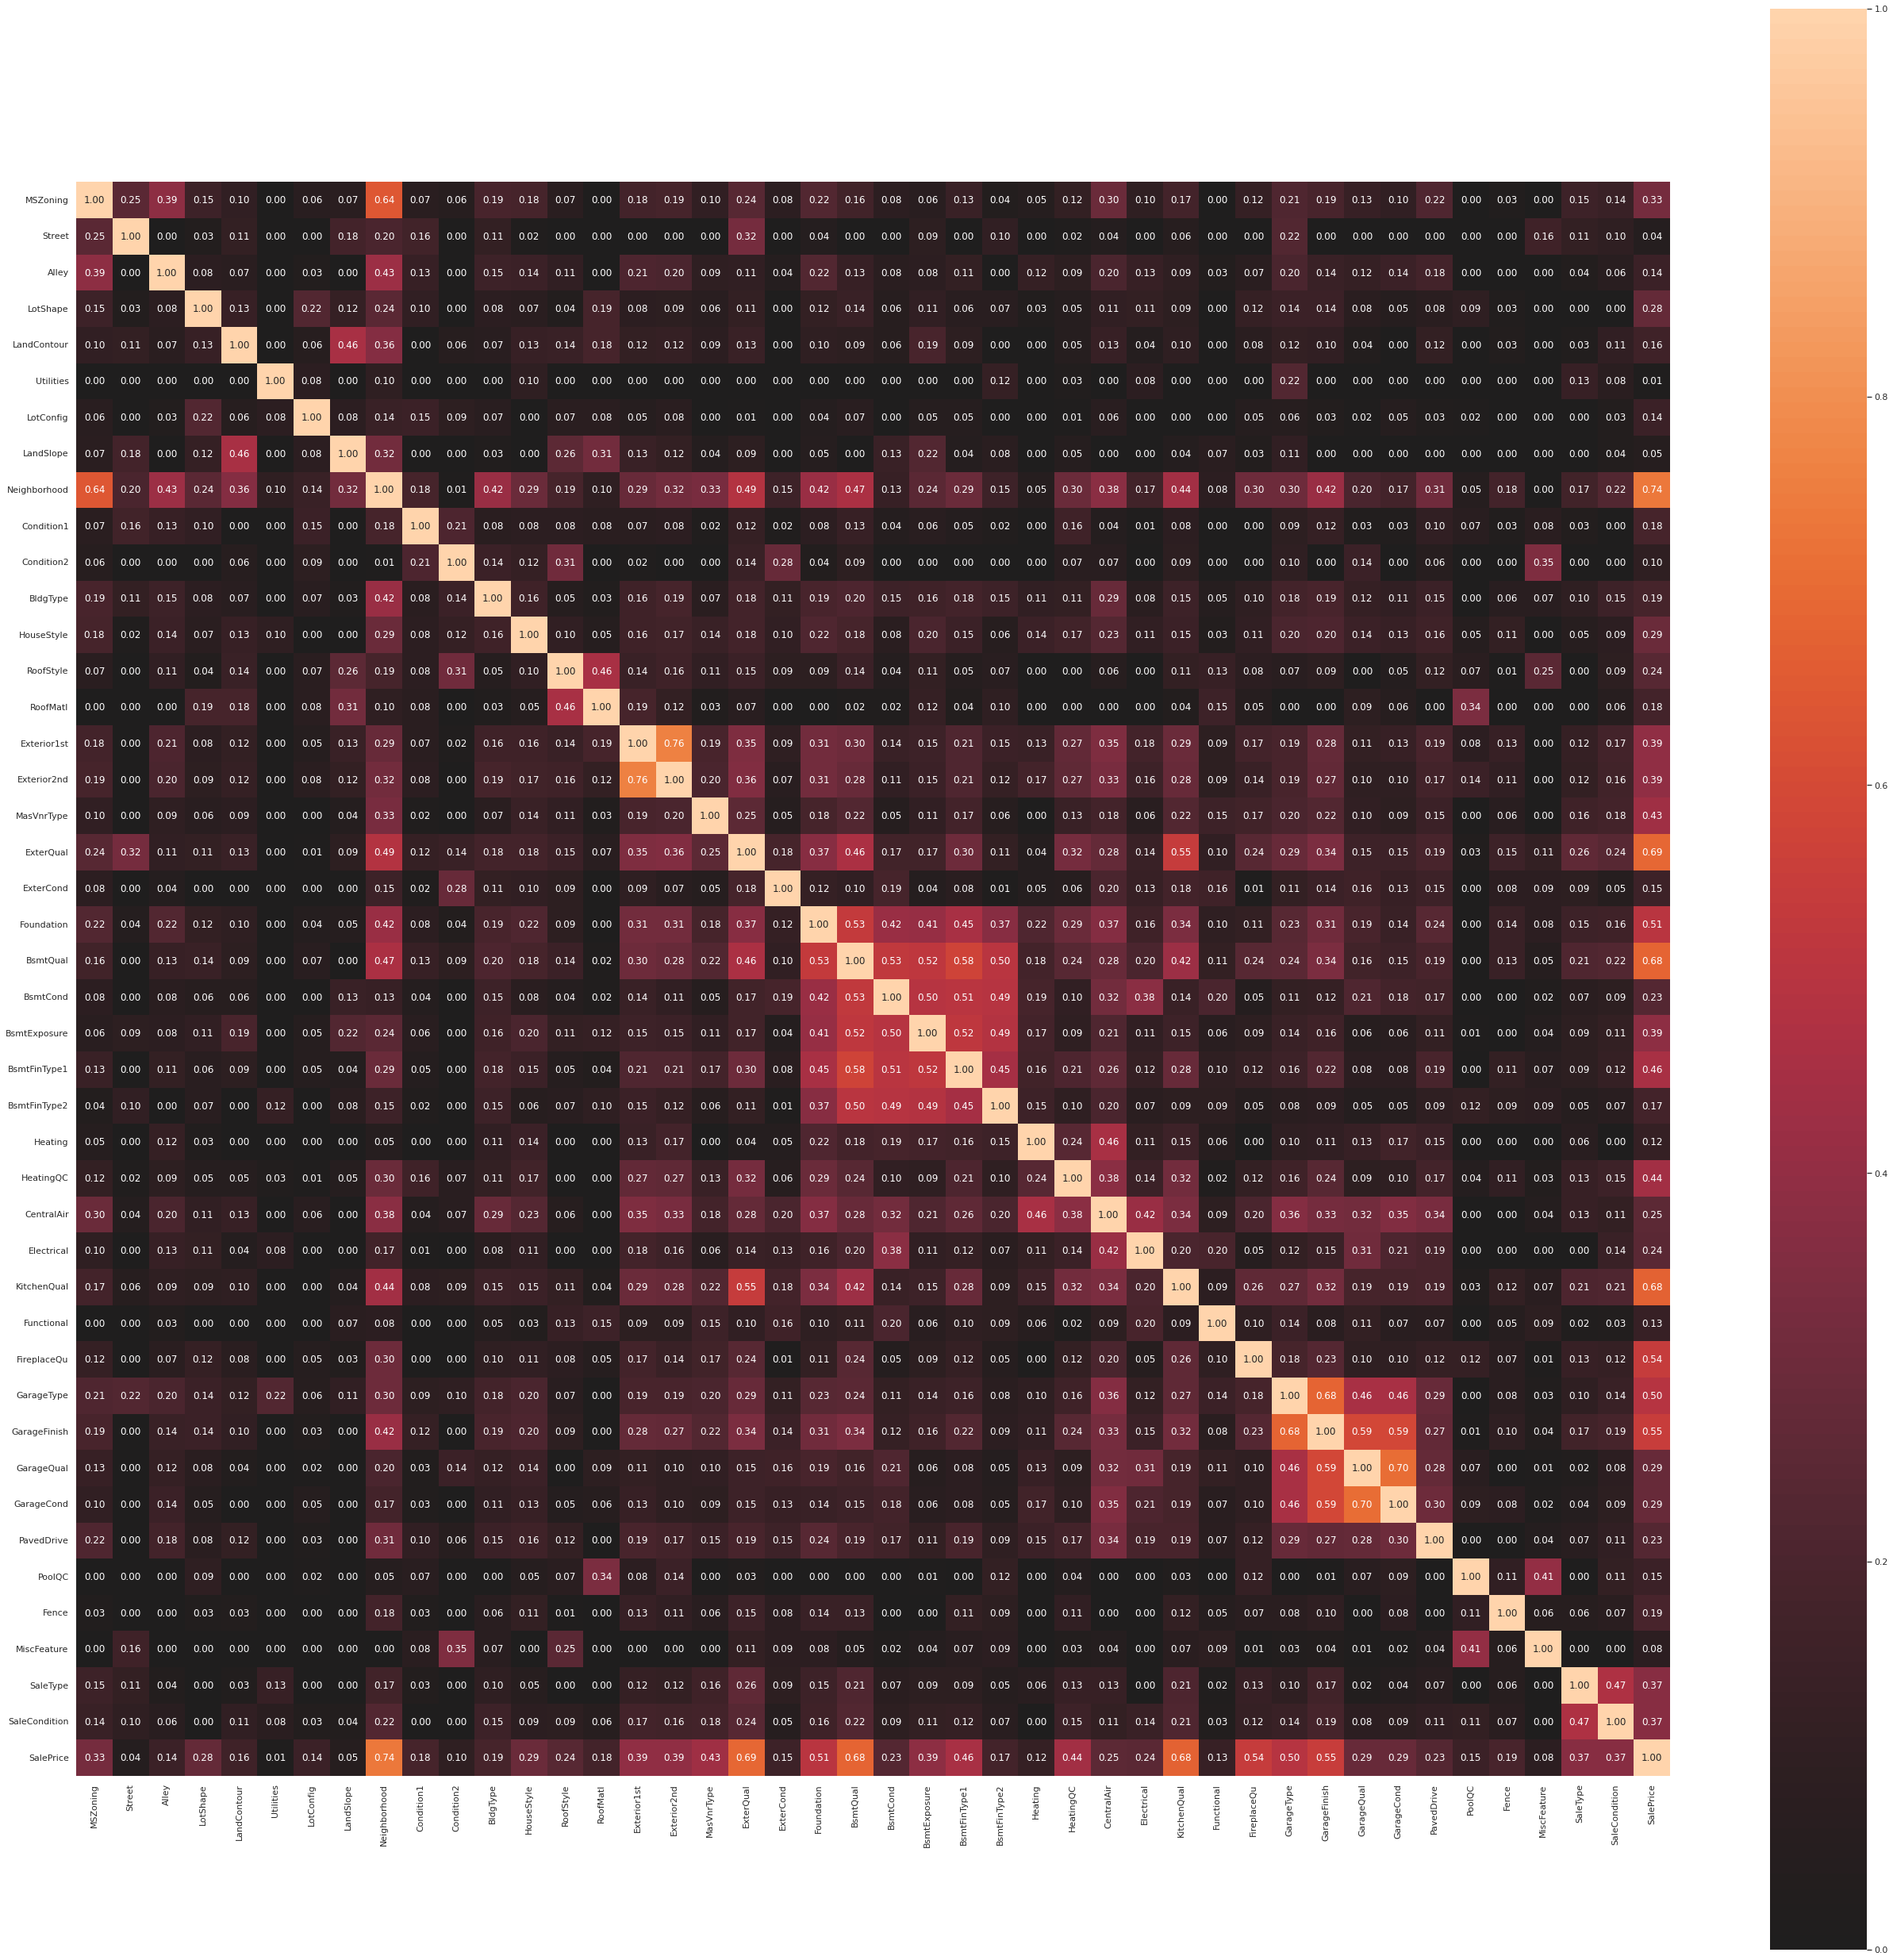

{'ax': <AxesSubplot:>,
 'corr':                MSZoning    Street     Alley  ...  SaleType  SaleCondition  SalePrice
 MSZoning       1.000000  0.249384  0.388841  ...  0.150903       0.136065   0.327963
 Street         0.249384  1.000000  0.000000  ...  0.110886       0.099458   0.041036
 Alley          0.388841  0.000000  1.000000  ...  0.035549       0.064614   0.142855
 LotShape       0.152191  0.033770  0.079801  ...  0.000000       0.001923   0.276362
 LandContour    0.102102  0.113834  0.071435  ...  0.030262       0.107176   0.160605
 Utilities      0.000000  0.000000  0.000000  ...  0.130824       0.076153   0.014314
 LotConfig      0.063847  0.000000  0.034874  ...  0.000000       0.034114   0.144981
 LandSlope      0.071793  0.176221  0.000000  ...  0.000000       0.037628   0.051784
 Neighborhood   0.640629  0.198616  0.428513  ...  0.169461       0.219449   0.738630
 Condition1     0.071332  0.164925  0.126371  ...  0.033961       0.000000   0.180640
 Condition2     0.05871

In [17]:
# http://shakedzy.xyz/dython/getting_started/examples/
associations(df_train_cat, figsize=(45,45))

<span style="color:blue">Observations:</span><br>
<strong>Features with > 50% positive correlation to our dependent variable SalesPrice:</strong><br>Neighborhood <br>ExterQual <br>Foundation <br>BsmtQual <br>FireplaceQu <br>GarageType <br>GarageFinish

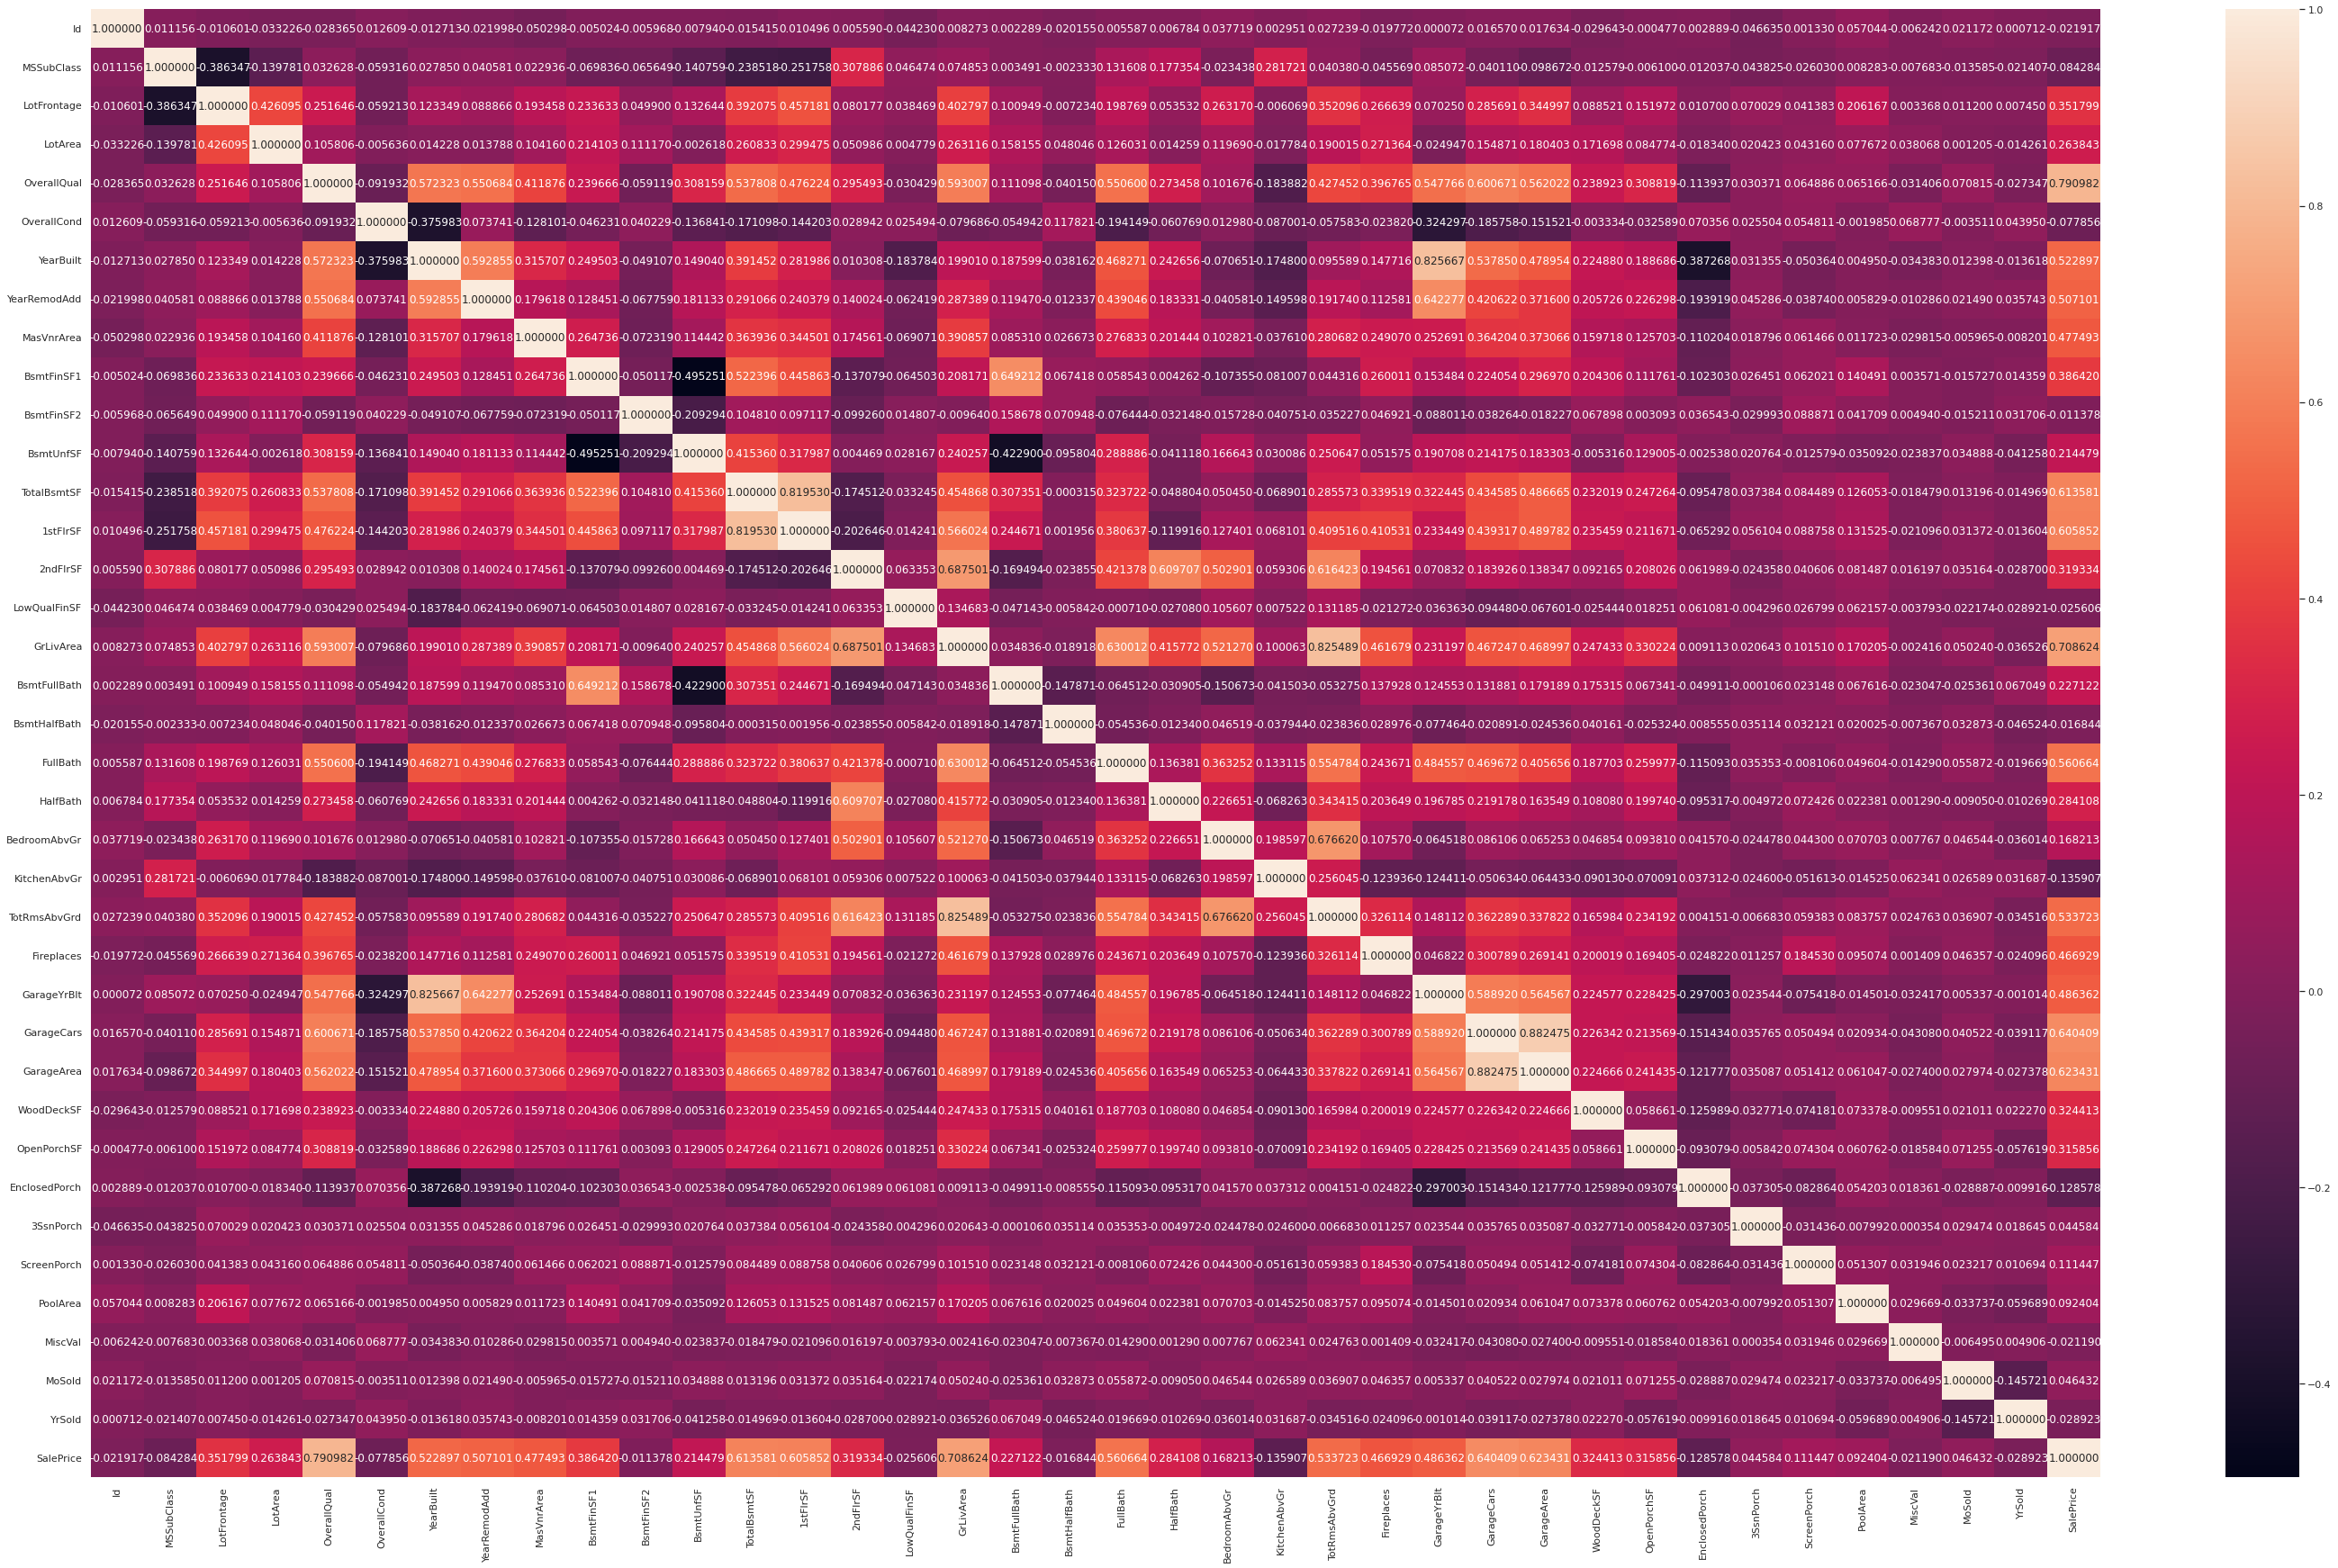

In [18]:
# credit: https://www.kaggle.com/gorkembakir/hp-eda
f, ax =plt.subplots(figsize=(50,30))
sns.heatmap(df_train.corr(),annot=True, fmt="1f", ax=ax)
plt.show()

<span style="color:blue">Observations:</span><br>
<strong>Features with > 50% positive correlation to our dependent variable SalesPrice:</strong><br>
OverallQual<br>
YearBuilt<br>
YearRemodAdd<br>
TotalBsmtSF<br>
1stFlSF<br>
GrLivArea<br>
FullBath<br>
TotRmsAbvGrd<br>
GarageCars<br>
GarageArea<br>

<h4>Potential Predictor of the dependent variable (SalePrice) #1: OverallQual</h4>

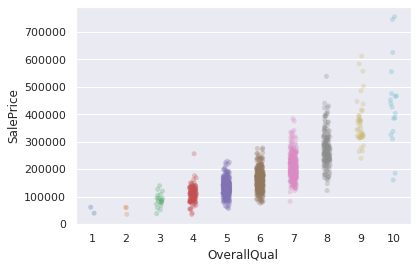

In [19]:
sns.stripplot(x='OverallQual', y='SalePrice', data=df_train, alpha=0.3, jitter=True);

<span style="color:blue">Observations:</span><br>
This appears to confirm that as overall quality increase, so does sale price.

In [20]:
oq=df_train[["OverallQual","SalePrice"]].groupby(["OverallQual"], as_index=False).count().sort_values(by="SalePrice",ascending="True")
oq

OverallQual  SalePrice
0            1          2
1            2          3
9           10         18
2            3         20
8            9         43
3            4        116
7            8        168
6            7        319
5            6        374
4            5        397

This shows us counts associated with each overall quality score.

In [21]:
oq2=df_train[["OverallQual","SalePrice"]].groupby(["OverallQual"], as_index=False).mean().sort_values(by="SalePrice",ascending="True")
oq2

OverallQual      SalePrice
0            1   50150.000000
1            2   51770.333333
2            3   87473.750000
3            4  108420.655172
4            5  133523.347607
5            6  161603.034759
6            7  207716.423197
7            8  274735.535714
8            9  367513.023256
9           10  438588.388889

<span style="color:blue">Observations:</span><br>
This supports the idea that as sales price increases, so does quality score.

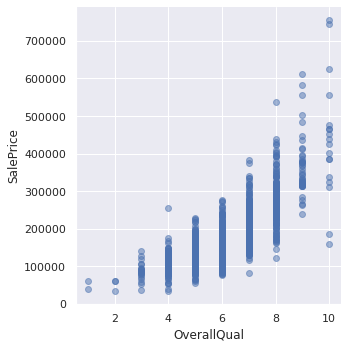

In [22]:
sns.lmplot(x='OverallQual', y='SalePrice', data=df_train, fit_reg=False, scatter_kws={'alpha':0.5});

<h4>Potential Predictor of the dependent variable (SalePrice) #2: YearRemodAdd</h4>

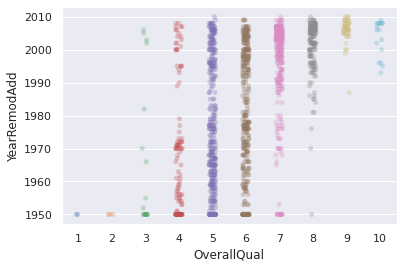

In [23]:
sns.stripplot(x='OverallQual', y='YearRemodAdd', data=df_train, alpha=0.3, jitter=True);

In [24]:
yra2=df_train[["YearRemodAdd","SalePrice"]].groupby(["YearRemodAdd"], as_index=False).mean().sort_values(by="SalePrice",ascending="True")
yra2

YearRemodAdd      SalePrice
2           1952  110398.600000
0           1950  117463.056180
21          1971  120230.555556
4           1954  121142.857143
32          1982  121271.428571
..           ...            ...
57          2007  224807.250000
56          2006  229471.134021
58          2008  269709.100000
59          2009  284085.391304
60          2010  336963.500000

[61 rows x 2 columns]

<span style="color:blue">Observations:</span><br>
This supports the idea that the more recently remodeled homes are selling for higher prices.

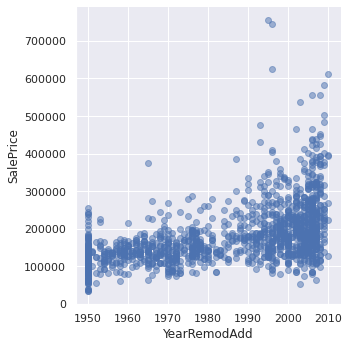

In [25]:
sns.lmplot(x='YearRemodAdd', y='SalePrice', data=df_train, fit_reg=False, scatter_kws={'alpha':0.5});

<span style="color:blue">Observations:</span><br>
It's not super strong, but it does look like there is increased density around the later years and only later years have very high sale prices.

<h4>Potential Predictor of the dependent variable (SalePrice) #2: GarageArea</h4>

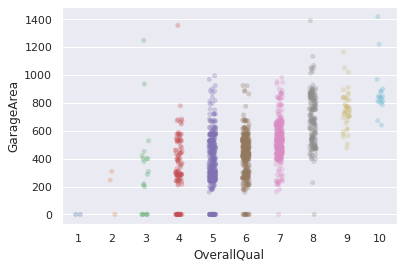

In [26]:
sns.stripplot(x='OverallQual', y='GarageArea', data=df_train, alpha=0.3, jitter=True);

<span style="color:blue">Observations:</span><br>
This one is not as highly correlated. This says that garage area is not the only determining factor of a higher sales price.

In [27]:
ga=df_train[["GarageArea","SalePrice"]].groupby(["GarageArea"], as_index=False).mean().sort_values(by="SalePrice",ascending="True")
ga

GarageArea  SalePrice
75          350    60000.0
42          287    72500.0
5           189    78000.0
8           200    79125.0
437        1248    81000.0
..          ...        ...
325         716   556581.0
428        1020   582933.0
364         807   625000.0
368         813   745000.0
377         832   755000.0

[441 rows x 2 columns]

<span style="color:blue">Observations:</span><br>
Again, some home with smaller garages are selling for a higher price, supporting the idea that garage size alone is not a predictor of sale price.

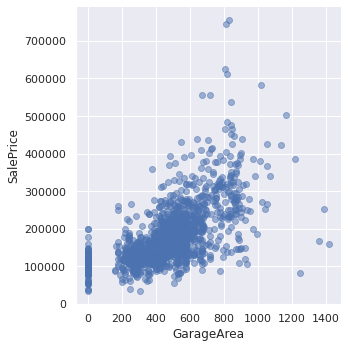

In [28]:
sns.lmplot(x='GarageArea', y='SalePrice', data=df_train, fit_reg=False, scatter_kws={'alpha':0.5});

<span style="color:blue">Observations:</span><br>
There must be another factor that would cause this feature to correlate better with sale price. 

<h3>4. Engage in feature creation by splitting, merging, or otherwise generating a new predictor.</h3>

Create a feature that indicates if the home has a garage or not.

In [29]:
for index, row in enumerate(df_train["GarageType"]):
    #print(row)
    if pd.isna(row):
        df_train.loc[index, "HasGarage"] = "Yes"
    else:
        df_train.loc[index, "HasGarage"] = "No"

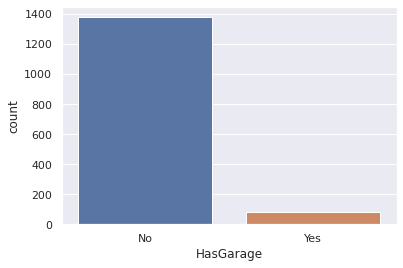

In [30]:
#sns.lmplot(x='HasGarage', y='SalePrice', data=df_train, fit_reg=False, scatter_kws={'alpha':0.5});
sns.countplot(x='HasGarage', data=df_train);

Did a little check-see to ensure we have some of each value coming through.

<h3>5. Using the dependent variable, perform both min-max and standard scaling in Python.</h3>

<h4>min-max</h4>

                0            1   ...           36           37
count  1460.000000  1460.000000  ...  1460.000000  1460.000000
mean      0.500000     0.217043  ...     0.453938     0.202779
std       0.288972     0.248827  ...     0.332024     0.110321
min       0.000000     0.000000  ...     0.000000     0.000000
25%       0.250000     0.000000  ...     0.250000     0.132030
50%       0.500000     0.176471  ...     0.500000     0.177892
75%       0.750000     0.294118  ...     0.750000     0.248715
max       1.000000     1.000000  ...     1.000000     1.000000

[8 rows x 38 columns]


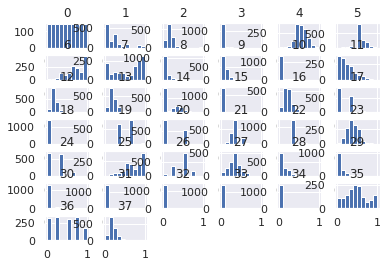

In [31]:
# https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/
# retrieve just the numeric input values
data = df_train.select_dtypes(include=[np.number])
#print(data)
# perform a robust scaler transform of the dataset
trans = MinMaxScaler()
data_trans = trans.fit_transform(data)
# convert the array back to a dataframe
dataset = pd.DataFrame(data_trans)
# summarize
print(dataset.describe())
# histograms of the variables
dataset.hist()
plt.show()

Distributions have been adjusted to between 0 and 1 min-max.

<h4>standard scaling</h4>

                 0             1   ...            36            37
count  1.460000e+03  1.460000e+03  ...  1.460000e+03  1.460000e+03
mean   8.243026e-17 -1.504124e-16  ...  3.566101e-14  1.180182e-16
std    1.000343e+00  1.000343e+00  ...  1.000343e+00  1.000343e+00
min   -1.730865e+00 -8.725628e-01  ... -1.367655e+00 -1.838704e+00
25%   -8.654324e-01 -8.725628e-01  ... -6.144386e-01 -6.415162e-01
50%    0.000000e+00 -1.631095e-01  ...  1.387775e-01 -2.256643e-01
75%    8.654324e-01  3.098594e-01  ...  8.919936e-01  4.165294e-01
max    1.730865e+00  3.147673e+00  ...  1.645210e+00  7.228819e+00

[8 rows x 38 columns]


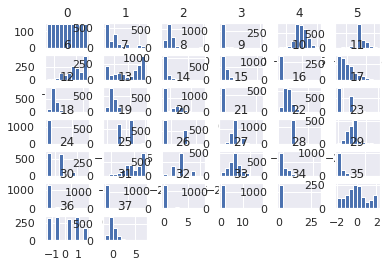

In [32]:
# https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/
data = df_train.select_dtypes(include=[np.number])
#print(data)
# perform a robust scaler transform of the dataset
trans = StandardScaler()
data_trans = trans.fit_transform(data)
# convert the array back to a dataframe
dataset = pd.DataFrame(data_trans)
# summarize
print(dataset.describe())
# histograms of the variables
dataset.hist()
plt.show()

Distributions have been adjusted and that the mean is a very small number close to zero and the standard deviation is very close to 1.0 for each variable.

## Feature Reduction

<h3>Remove insignificant features with < .5 correlation with SalesPrice</h3>

In [33]:
corr_matrix = df_train.corr()
corr_matrix

Id  MSSubClass  LotFrontage  ...    MoSold    YrSold  SalePrice
Id             1.000000    0.011156    -0.010601  ...  0.021172  0.000712  -0.021917
MSSubClass     0.011156    1.000000    -0.386347  ... -0.013585 -0.021407  -0.084284
LotFrontage   -0.010601   -0.386347     1.000000  ...  0.011200  0.007450   0.351799
LotArea       -0.033226   -0.139781     0.426095  ...  0.001205 -0.014261   0.263843
OverallQual   -0.028365    0.032628     0.251646  ...  0.070815 -0.027347   0.790982
OverallCond    0.012609   -0.059316    -0.059213  ... -0.003511  0.043950  -0.077856
YearBuilt     -0.012713    0.027850     0.123349  ...  0.012398 -0.013618   0.522897
YearRemodAdd  -0.021998    0.040581     0.088866  ...  0.021490  0.035743   0.507101
MasVnrArea    -0.050298    0.022936     0.193458  ... -0.005965 -0.008201   0.477493
BsmtFinSF1    -0.005024   -0.069836     0.233633  ... -0.015727  0.014359   0.386420
BsmtFinSF2    -0.005968   -0.065649     0.049900  ... -0.015211  0.031706  -0.011378
BsmtUnfSF     -0.007940   -0.140759     0.132644  ...  0.034888 -0.041258   0.214479
TotalBsmtSF   -0.015415   -0.238518     0.392075  ...  0.013196 -0.014969   0.613581
1stFlrSF       0.010496   -0.251758     0.457181  ...  0.031372 -0.013604   0.605852
2ndFlrSF       0.005590    0.307886     0.080177  ...  0.035164 -0.028700   0.319334
LowQualFinSF  -0.044230    0.046474     0.038469  ... -0.022174 -0.028921  -0.025606
GrLivArea      0.008273    0.074853     0.402797  ...  0.050240 -0.036526   0.708624
BsmtFullBath   0.002289    0.003491     0.100949  ... -0.025361  0.067049   0.227122
BsmtHalfBath  -0.020155   -0.002333    -0.007234  ...  0.032873 -0.046524  -0.016844
FullBath       0.005587    0.131608     0.198769  ...  0.055872 -0.019669   0.560664
HalfBath       0.006784    0.177354     0.053532  ... -0.009050 -0.010269   0.284108
BedroomAbvGr   0.037719   -0.023438     0.263170  ...  0.046544 -0.036014   0.168213
KitchenAbvGr   0.002951    0.281721    -0.006069  ...  0.026589  0.031687  -0.135907
TotRmsAbvGrd   0.027239    0.040380     0.352096  ...  0.036907 -0.034516   0.533723
Fireplaces    -0.019772   -0.045569     0.266639  ...  0.046357 -0.024096   0.466929
GarageYrBlt    0.000072    0.085072     0.070250  ...  0.005337 -0.001014   0.486362
GarageCars     0.016570   -0.040110     0.285691  ...  0.040522 -0.039117   0.640409
GarageArea     0.017634   -0.098672     0.344997  ...  0.027974 -0.027378   0.623431
WoodDeckSF    -0.029643   -0.012579     0.088521  ...  0.021011  0.022270   0.324413
OpenPorchSF   -0.000477   -0.006100     0.151972  ...  0.071255 -0.057619   0.315856
EnclosedPorch  0.002889   -0.012037     0.010700  ... -0.028887 -0.009916  -0.128578
3SsnPorch     -0.046635   -0.043825     0.070029  ...  0.029474  0.018645   0.044584
ScreenPorch    0.001330   -0.026030     0.041383  ...  0.023217  0.010694   0.111447
PoolArea       0.057044    0.008283     0.206167  ... -0.033737 -0.059689   0.092404
MiscVal       -0.006242   -0.007683     0.003368  ... -0.006495  0.004906  -0.021190
MoSold         0.021172   -0.013585     0.011200  ...  1.000000 -0.145721   0.046432
YrSold         0.000712   -0.021407     0.007450  ... -0.145721  1.000000  -0.028923
SalePrice     -0.021917   -0.084284     0.351799  ...  0.046432 -0.028923   1.000000

[38 rows x 38 columns]

In [34]:
# https://www.kaggle.com/omkaarp/house-prices-regression-techniques-submission
corr_matrix['SalePrice'][(corr_matrix["SalePrice"] > 0.40) | (corr_matrix["SalePrice"] < -0.40)]

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.477493
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
Fireplaces      0.466929
GarageYrBlt     0.486362
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [35]:
significant_cols = list(corr_matrix['SalePrice'][(corr_matrix["SalePrice"] > 0.5) | (corr_matrix["SalePrice"] < -0.5)].index)
print(significant_cols)
sig_cat_cols = ['Neighborhood', 'ExterQual', 'Foundation', 'BsmtQual', 'FireplaceQu', 'GarageType', 'GarageFinish']
for col in sig_cat_cols:
  significant_cols.append(col)
print(significant_cols)

train = df_train[significant_cols]

significant_cols.remove('SalePrice')
print(f'Number of significant features: {len(significant_cols)} \n Those features are: {significant_cols}')

['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'SalePrice']
['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'SalePrice', 'Neighborhood', 'ExterQual', 'Foundation', 'BsmtQual', 'FireplaceQu', 'GarageType', 'GarageFinish']
Number of significant features: 17 
 Those features are: ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'Neighborhood', 'ExterQual', 'Foundation', 'BsmtQual', 'FireplaceQu', 'GarageType', 'GarageFinish']


In [36]:
train.shape

(1460, 18)

Visualize the relationship between the significant independent variables and our dependent variable (SalePrice) as well as correlation with each other

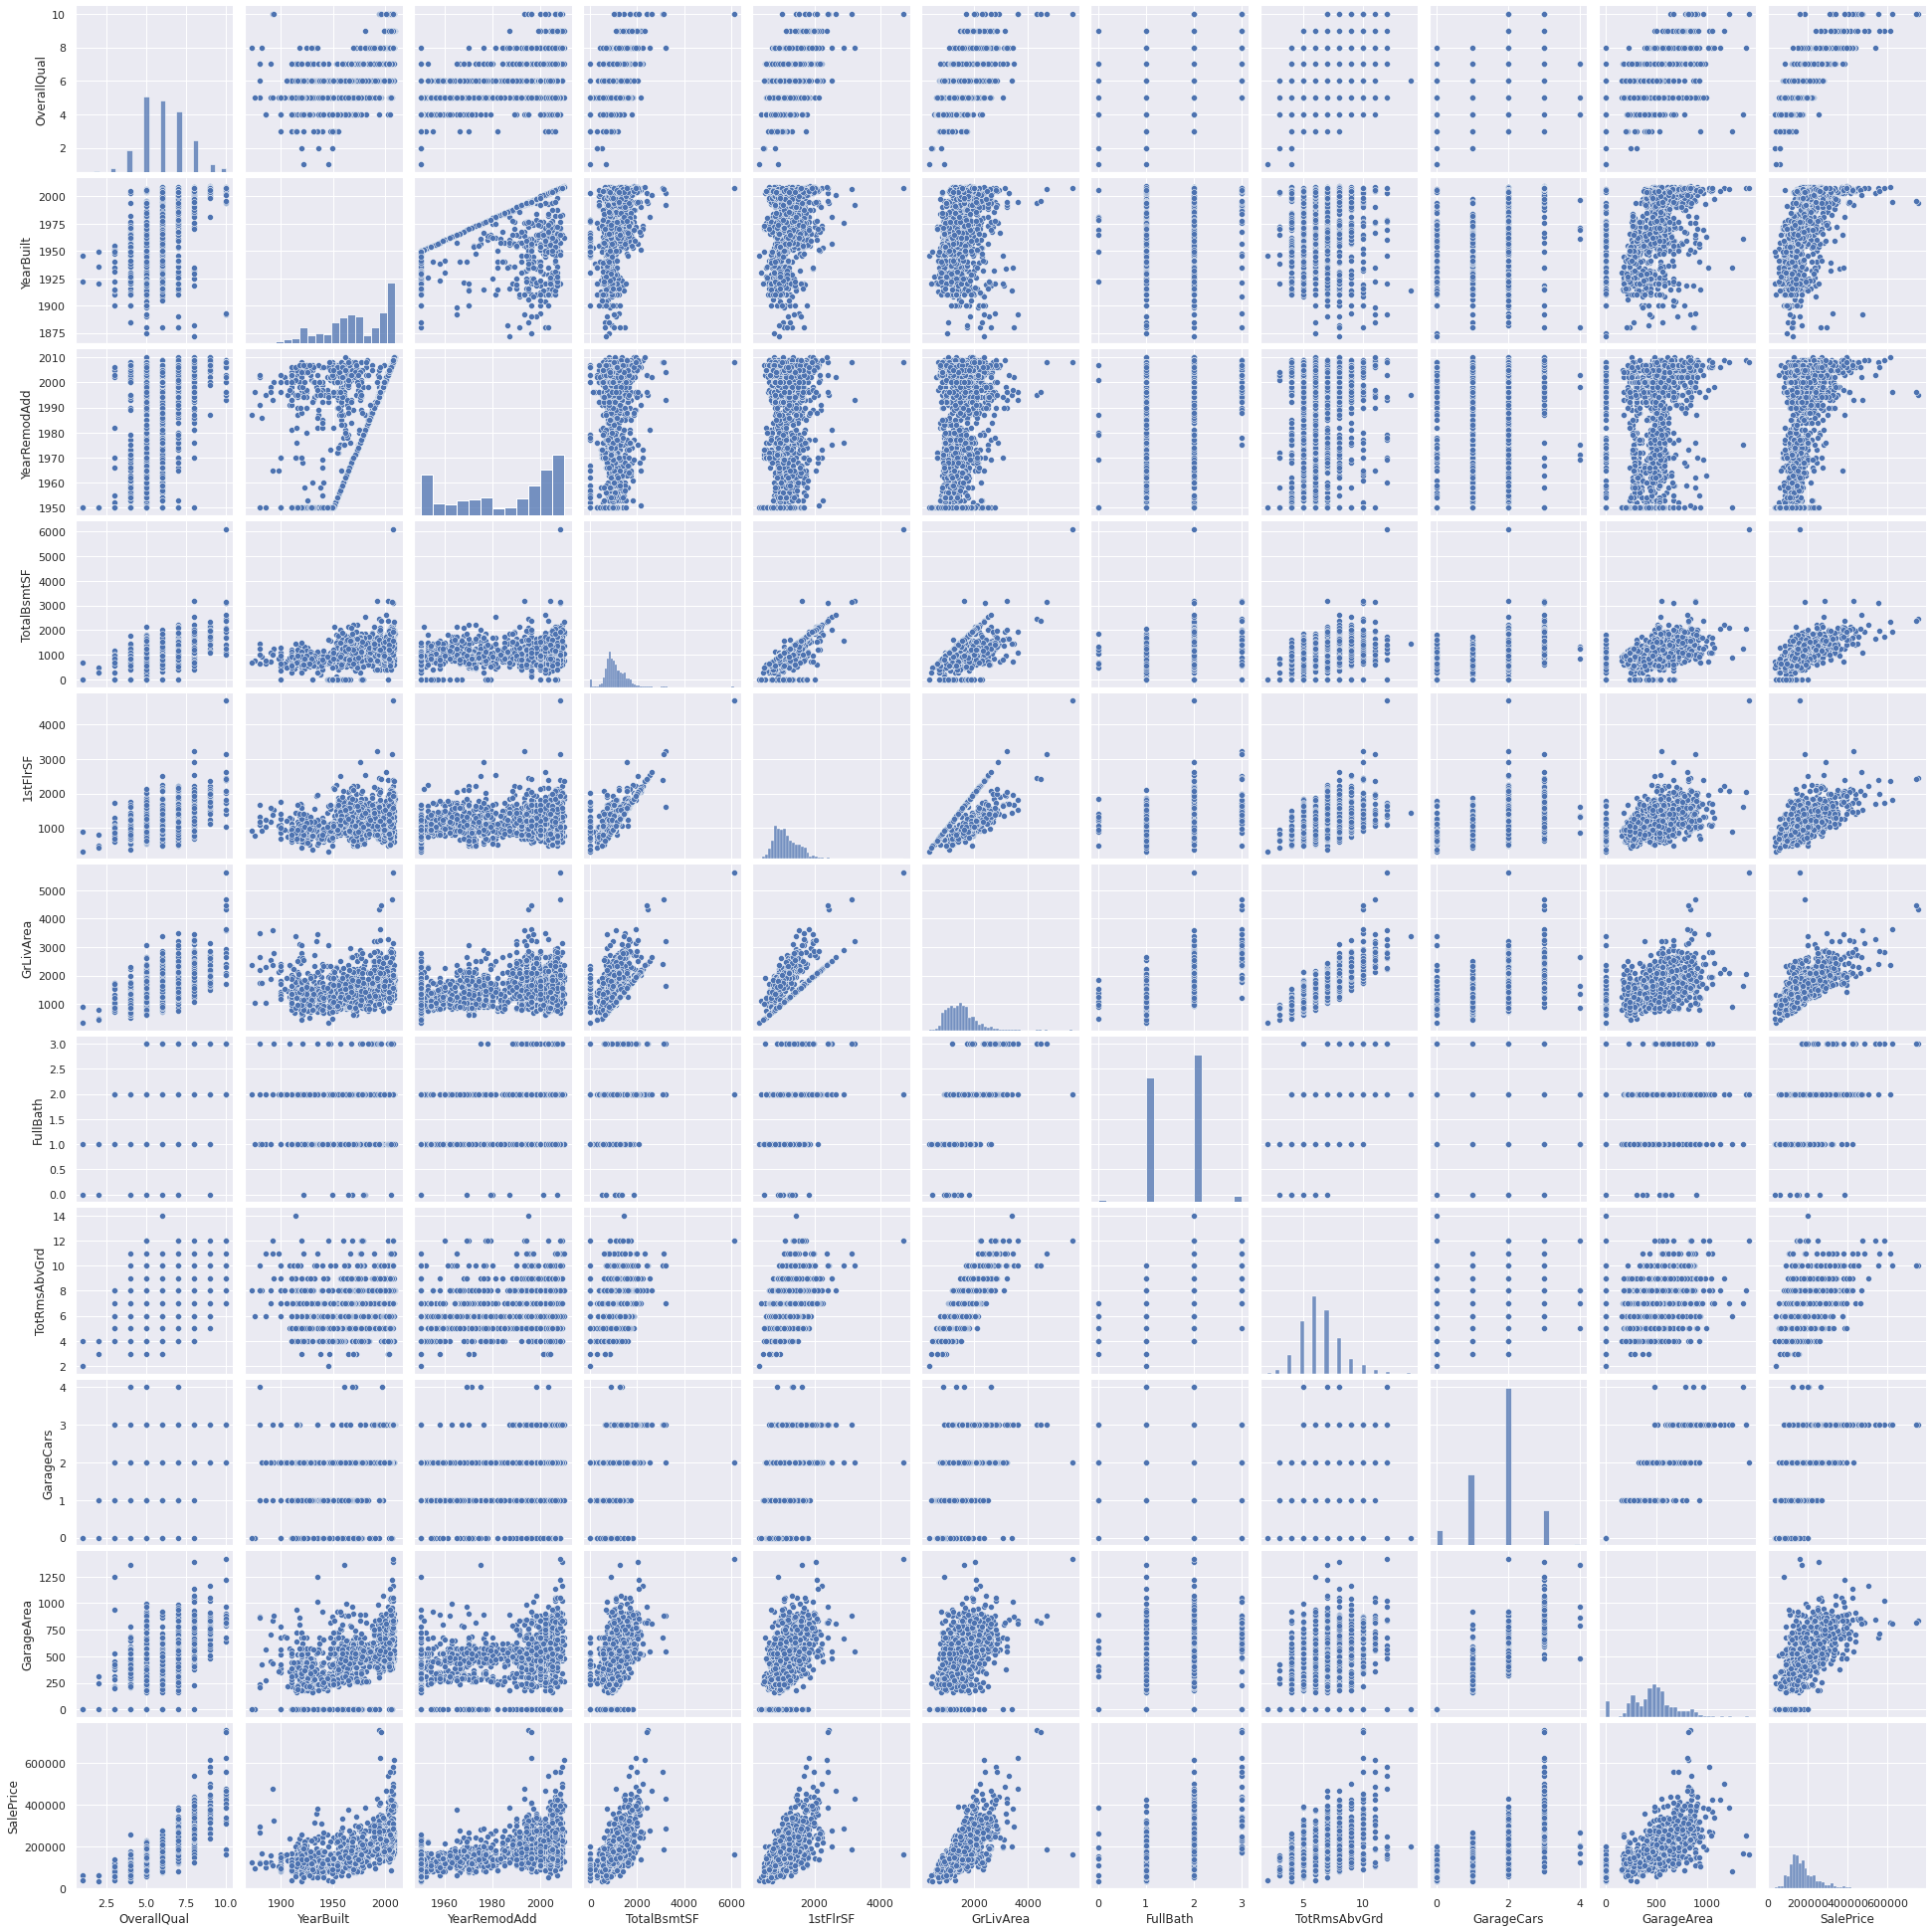

In [37]:
sns.pairplot(train)

My instinct is to remove obviously correlated features like GrLivArea, 1stFlrSF, and TotalBsmtSF but I'll leave them in for now. The model might give that more weight because there are several features that provide very similar points to fit.

## Preprocessing - Imputing and Scaling the data

In [38]:
train.describe()

OverallQual    YearBuilt  ...   GarageArea      SalePrice
count  1460.000000  1460.000000  ...  1460.000000    1460.000000
mean      6.099315  1971.267808  ...   472.980137  180921.195890
std       1.382997    30.202904  ...   213.804841   79442.502883
min       1.000000  1872.000000  ...     0.000000   34900.000000
25%       5.000000  1954.000000  ...   334.500000  129975.000000
50%       6.000000  1973.000000  ...   480.000000  163000.000000
75%       7.000000  2000.000000  ...   576.000000  214000.000000
max      10.000000  2010.000000  ...  1418.000000  755000.000000

[8 rows x 11 columns]

<h3>Convert Categorical data to numerical</h3>

In [39]:
added_features = []
def transform_data(feature):
  ordinal_encoder = OrdinalEncoder()
  feature_encoded = ordinal_encoder.fit_transform(train[[feature]])
  feature_ext = "_code"
  feature_name = feature + feature_ext
  added_features.append(feature_name)
  train[feature_name] = feature_encoded

In [40]:
#added_features = []
for feat in sig_cat_cols:
  transform_data(feat)
  #added_features.append(feat)

print(added_features)
train.describe()

['Neighborhood_code', 'ExterQual_code', 'Foundation_code', 'BsmtQual_code', 'FireplaceQu_code', 'GarageType_code', 'GarageFinish_code']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

OverallQual    YearBuilt  ...  GarageType_code  GarageFinish_code
count  1460.000000  1460.000000  ...      1379.000000        1379.000000
mean      6.099315  1971.267808  ...         2.279188           1.183466
std       1.382997    30.202904  ...         1.785588           0.812896
min       1.000000  1872.000000  ...         0.000000           0.000000
25%       5.000000  1954.000000  ...         1.000000           0.000000
50%       6.000000  1973.000000  ...         1.000000           1.000000
75%       7.000000  2000.000000  ...         5.000000           2.000000
max      10.000000  2010.000000  ...         5.000000           2.000000

[8 rows x 18 columns]

In [41]:
train.head()

OverallQual  YearBuilt  ...  GarageType_code  GarageFinish_code
0            7       2003  ...              1.0                1.0
1            6       1976  ...              1.0                1.0
2            7       2001  ...              1.0                1.0
3            7       1915  ...              5.0                2.0
4            8       2000  ...              1.0                1.0

[5 rows x 25 columns]

## <h3>Find and Fill in missing Values</h3>

In [42]:
train[significant_cols].isna().sum()

OverallQual       0
YearBuilt         0
YearRemodAdd      0
TotalBsmtSF       0
1stFlrSF          0
GrLivArea         0
FullBath          0
TotRmsAbvGrd      0
GarageCars        0
GarageArea        0
Neighborhood      0
ExterQual         0
Foundation        0
BsmtQual         37
FireplaceQu     690
GarageType       81
GarageFinish     81
dtype: int64

we have some missing values to fill in


In [43]:
train['BsmtQual'].fillna(0, inplace=True)
train['FireplaceQu'].fillna(0, inplace=True)
train['GarageType'].fillna(0, inplace=True)
train['GarageFinish'].fillna(0, inplace=True)
train[significant_cols].isna().sum()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


OverallQual     0
YearBuilt       0
YearRemodAdd    0
TotalBsmtSF     0
1stFlrSF        0
GrLivArea       0
FullBath        0
TotRmsAbvGrd    0
GarageCars      0
GarageArea      0
Neighborhood    0
ExterQual       0
Foundation      0
BsmtQual        0
FireplaceQu     0
GarageType      0
GarageFinish    0
dtype: int64

## <h3>Scaling</h3>

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   OverallQual        1460 non-null   int64  
 1   YearBuilt          1460 non-null   int64  
 2   YearRemodAdd       1460 non-null   int64  
 3   TotalBsmtSF        1460 non-null   int64  
 4   1stFlrSF           1460 non-null   int64  
 5   GrLivArea          1460 non-null   int64  
 6   FullBath           1460 non-null   int64  
 7   TotRmsAbvGrd       1460 non-null   int64  
 8   GarageCars         1460 non-null   int64  
 9   GarageArea         1460 non-null   int64  
 10  SalePrice          1460 non-null   int64  
 11  Neighborhood       1460 non-null   object 
 12  ExterQual          1460 non-null   object 
 13  Foundation         1460 non-null   object 
 14  BsmtQual           1460 non-null   object 
 15  FireplaceQu        1460 non-null   object 
 16  GarageType         1460 

Another check for nulls:

In [45]:
train.isna().sum()

OverallQual            0
YearBuilt              0
YearRemodAdd           0
TotalBsmtSF            0
1stFlrSF               0
GrLivArea              0
FullBath               0
TotRmsAbvGrd           0
GarageCars             0
GarageArea             0
SalePrice              0
Neighborhood           0
ExterQual              0
Foundation             0
BsmtQual               0
FireplaceQu            0
GarageType             0
GarageFinish           0
Neighborhood_code      0
ExterQual_code         0
Foundation_code        0
BsmtQual_code         37
FireplaceQu_code     690
GarageType_code       81
GarageFinish_code     81
dtype: int64

In [46]:
train['BsmtQual_code'].fillna(0, inplace=True)
train['FireplaceQu_code'].fillna(0, inplace=True)
train['GarageType_code'].fillna(0, inplace=True)
train['GarageFinish_code'].fillna(0, inplace=True)
train[significant_cols].isna().sum()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


OverallQual     0
YearBuilt       0
YearRemodAdd    0
TotalBsmtSF     0
1stFlrSF        0
GrLivArea       0
FullBath        0
TotRmsAbvGrd    0
GarageCars      0
GarageArea      0
Neighborhood    0
ExterQual       0
Foundation      0
BsmtQual        0
FireplaceQu     0
GarageType      0
GarageFinish    0
dtype: int64

In [47]:
objs = train.select_dtypes(include=['object']).columns.tolist()
train = train.drop(columns=objs, axis=1)

In [48]:
floats = train.select_dtypes(include=['float64']).columns.tolist()
#print(floats)
for f in floats:
  train[f] = train[f].astype(int)

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   OverallQual        1460 non-null   int64
 1   YearBuilt          1460 non-null   int64
 2   YearRemodAdd       1460 non-null   int64
 3   TotalBsmtSF        1460 non-null   int64
 4   1stFlrSF           1460 non-null   int64
 5   GrLivArea          1460 non-null   int64
 6   FullBath           1460 non-null   int64
 7   TotRmsAbvGrd       1460 non-null   int64
 8   GarageCars         1460 non-null   int64
 9   GarageArea         1460 non-null   int64
 10  SalePrice          1460 non-null   int64
 11  Neighborhood_code  1460 non-null   int64
 12  ExterQual_code     1460 non-null   int64
 13  Foundation_code    1460 non-null   int64
 14  BsmtQual_code      1460 non-null   int64
 15  FireplaceQu_code   1460 non-null   int64
 16  GarageType_code    1460 non-null   int64
 17  GarageFinish_c

In [50]:
# MaxMin Scaling
trans = MinMaxScaler()
train_scale = trans.fit_transform(train)

# Modeling

## Linear Regression Model

In [51]:
y1 = train['SalePrice']
x1 = train[['OverallQual']]

lin_reg1 = LinearRegression()
lin_reg1.fit(x1,y1)

LinearRegression()

In [52]:
# look at summary statistics
x = sm.add_constant(x1)

mul_lm = sm.OLS(y1,x1).fit()
mul_lm.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                          1.879e+04
Date:                Sat, 22 Jan 2022   Prob (F-statistic):                        0.00
Time:                        17:43:07   Log-Likelihood:                         -17955.
No. Observations:                1460   AIC:                                  3.591e+04
Df Residuals:                    1459   BIC:                                  3.592e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
OverallQual  3.043e+04    222.032    137.068      0.000       3e+04    3.09e+04
==============================================================================
Omnibus:                      825.936   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10540.637
Skew:                           2.376   Prob(JB):                         0.00
Kurtosis:                      15.275   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Multiple Linear Regression Model

In [53]:
# dependent variable
y = train['SalePrice']
# independent variable
x = train.drop(columns=["SalePrice"], axis=1)
x.shape

(1460, 17)

In [54]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x, y)



LinearRegression()

In [55]:
# look at summary statistics
x = sm.add_constant(x)

mul_lm = sm.OLS(y,x).fit()
mul_lm.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     327.9
Date:                Sat, 22 Jan 2022   Prob (F-statistic):               0.00
Time:                        17:43:07   Log-Likelihood:                -17389.
No. Observations:                1460   AIC:                         3.481e+04
Df Residuals:                    1442   BIC:                         3.491e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -6.581e+05   1.46e+05     -4.497      0.000   -9.45e+05   -3.71e+05
OverallQual         1.52e+04   1205.505     12.610      0.000    1.28e+04    1.76e+04
YearBuilt           121.5691     58.081      2.093      0.037       7.636     235.502
YearRemodAdd        223.0665     62.112      3.591      0.000     101.226     344.907
TotalBsmtSF          25.9820      4.464      5.821      0.000      17.226      34.738
1stFlrSF              2.1241      5.068      0.419      0.675      -7.818      12.066
GrLivArea            49.1121      4.140     11.862      0.000      40.990      57.234
FullBath          -9027.0613   2577.369     -3.502      0.000   -1.41e+04   -3971.267
TotRmsAbvGrd        297.3125   1072.925      0.277      0.782   -1807.348    2401.973
GarageCars         1.081e+04   2973.069      3.636      0.000    4979.474    1.66e+04
GarageArea           15.2625      9.997      1.527      0.127      -4.347      34.872
Neighborhood_code   339.8219    163.114      2.083      0.037      19.855     659.789
ExterQual_code    -1.198e+04   1975.216     -6.063      0.000   -1.59e+04   -8101.284
Foundation_code   -2606.5509   1822.358     -1.430      0.153   -6181.308     968.206
BsmtQual_code     -9290.2238   1384.135     -6.712      0.000    -1.2e+04   -6575.091
FireplaceQu_code   1422.1978    682.307      2.084      0.037      83.778    2760.618
GarageType_code    -924.9739    681.170     -1.358      0.175   -2261.163     411.216
GarageFinish_code -3879.7112   1506.804     -2.575      0.010   -6835.474    -923.949
==============================================================================
Omnibus:                      644.964   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            88472.597
Skew:                          -1.004   Prob(JB):                         0.00
Kurtosis:                      41.083   Cond. No.                     5.57e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.57e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**The multicolinearity warning is probably due to the note above about dependent variables that look highly correlated like the square footage of the basement and first floor.<br>
This model has a lower R-squared value and isn't performing as well as the single linear regression model, but I will submit this model because I'm interestedin seeing how it stacks up on Kaggle.

Create test data

In [56]:
def transform_data(feature):
  ordinal_encoder = OrdinalEncoder()
  feature_encoded = ordinal_encoder.fit_transform(test[[feature]])
  feature_ext = "_code"
  feature_name = feature + feature_ext
  test[feature_name] = feature_encoded

In [57]:
test = df_test
for feat in sig_cat_cols:
  transform_data(feat)

test.describe()

Id   MSSubClass  ...  GarageType_code  GarageFinish_code
count  1459.000000  1459.000000  ...      1383.000000        1381.000000
mean   2190.000000    57.378341  ...         2.288503           1.186821
std     421.321334    42.746880  ...         1.795614           0.826990
min    1461.000000    20.000000  ...         0.000000           0.000000
25%    1825.500000    20.000000  ...         1.000000           0.000000
50%    2190.000000    50.000000  ...         1.000000           1.000000
75%    2554.500000    70.000000  ...         5.000000           2.000000
max    2919.000000   190.000000  ...         5.000000           2.000000

[8 rows x 44 columns]

In [58]:
test[significant_cols].isna().sum()

OverallQual       0
YearBuilt         0
YearRemodAdd      0
TotalBsmtSF       1
1stFlrSF          0
GrLivArea         0
FullBath          0
TotRmsAbvGrd      0
GarageCars        1
GarageArea        1
Neighborhood      0
ExterQual         0
Foundation        0
BsmtQual         44
FireplaceQu     730
GarageType       76
GarageFinish     78
dtype: int64

In [59]:
test['TotalBsmtSF'].fillna(0, inplace=True)
test['GarageCars'].fillna(0, inplace=True)
test['GarageArea'].fillna(0, inplace=True)
test['BsmtQual'].fillna(0, inplace=True)
test['FireplaceQu'].fillna(0, inplace=True)
test['GarageType'].fillna(0, inplace=True)
test['GarageFinish'].fillna(0, inplace=True)
test[significant_cols].isna().sum()

OverallQual     0
YearBuilt       0
YearRemodAdd    0
TotalBsmtSF     0
1stFlrSF        0
GrLivArea       0
FullBath        0
TotRmsAbvGrd    0
GarageCars      0
GarageArea      0
Neighborhood    0
ExterQual       0
Foundation      0
BsmtQual        0
FireplaceQu     0
GarageType      0
GarageFinish    0
dtype: int64

In [60]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 87 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 1459 non-null   int64  
 1   MSSubClass         1459 non-null   int64  
 2   MSZoning           1455 non-null   object 
 3   LotFrontage        1232 non-null   float64
 4   LotArea            1459 non-null   int64  
 5   Street             1459 non-null   object 
 6   Alley              107 non-null    object 
 7   LotShape           1459 non-null   object 
 8   LandContour        1459 non-null   object 
 9   Utilities          1457 non-null   object 
 10  LotConfig          1459 non-null   object 
 11  LandSlope          1459 non-null   object 
 12  Neighborhood       1459 non-null   object 
 13  Condition1         1459 non-null   object 
 14  Condition2         1459 non-null   object 
 15  BldgType           1459 non-null   object 
 16  HouseStyle         1459 

Drop Features not used for prediction

In [61]:
#print(significant_cols)
#print(added_features)
for a in added_features:
  significant_cols.append(a)
#print(significant_cols)
test_features = test[significant_cols]
test_features.describe()

OverallQual    YearBuilt  ...  GarageType_code  GarageFinish_code
count  1459.000000  1459.000000  ...      1383.000000        1381.000000
mean      6.078821  1971.357779  ...         2.288503           1.186821
std       1.436812    30.390071  ...         1.795614           0.826990
min       1.000000  1879.000000  ...         0.000000           0.000000
25%       5.000000  1953.000000  ...         1.000000           0.000000
50%       6.000000  1973.000000  ...         1.000000           1.000000
75%       7.000000  2001.000000  ...         5.000000           2.000000
max      10.000000  2010.000000  ...         5.000000           2.000000

[8 rows x 17 columns]

## Cross Validation

In [62]:
def get_cv(scores):
     print("Scores:", scores)
     print("Mean:", scores.mean())
     print("Standard deviation:", scores.std())

In [63]:
# linear regression
lin_scores = cross_val_score(lin_reg1, x1, y1,
                              scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
get_cv(lin_rmse_scores)

Scores: [40722.27723135 45909.84079727 45027.0979542  51747.15783271
 59593.69061128 50090.37157212 43015.46757298 45365.57097083
 58912.31206005 42448.84950871]
Mean: 48283.263611151095
Standard deviation: 6323.558264546911


# <h2>Generate Submission</h2>

## <h3>Prepare Testing Data</h3>

In [64]:
test_features.isna().sum()

OverallQual            0
YearBuilt              0
YearRemodAdd           0
TotalBsmtSF            0
1stFlrSF               0
GrLivArea              0
FullBath               0
TotRmsAbvGrd           0
GarageCars             0
GarageArea             0
Neighborhood           0
ExterQual              0
Foundation             0
BsmtQual               0
FireplaceQu            0
GarageType             0
GarageFinish           0
Neighborhood_code      0
ExterQual_code         0
Foundation_code        0
BsmtQual_code         44
FireplaceQu_code     730
GarageType_code       76
GarageFinish_code     78
dtype: int64

In [65]:
test_features['BsmtQual_code'].fillna(0, inplace=True)
test_features['FireplaceQu_code'].fillna(0, inplace=True)
test_features['GarageType_code'].fillna(0, inplace=True)
test_features['GarageFinish_code'].fillna(0, inplace=True)
test_features[significant_cols].isna().sum()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


OverallQual          0
YearBuilt            0
YearRemodAdd         0
TotalBsmtSF          0
1stFlrSF             0
GrLivArea            0
FullBath             0
TotRmsAbvGrd         0
GarageCars           0
GarageArea           0
Neighborhood         0
ExterQual            0
Foundation           0
BsmtQual             0
FireplaceQu          0
GarageType           0
GarageFinish         0
Neighborhood_code    0
ExterQual_code       0
Foundation_code      0
BsmtQual_code        0
FireplaceQu_code     0
GarageType_code      0
GarageFinish_code    0
dtype: int64

In [66]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   OverallQual        1459 non-null   int64  
 1   YearBuilt          1459 non-null   int64  
 2   YearRemodAdd       1459 non-null   int64  
 3   TotalBsmtSF        1459 non-null   float64
 4   1stFlrSF           1459 non-null   int64  
 5   GrLivArea          1459 non-null   int64  
 6   FullBath           1459 non-null   int64  
 7   TotRmsAbvGrd       1459 non-null   int64  
 8   GarageCars         1459 non-null   float64
 9   GarageArea         1459 non-null   float64
 10  Neighborhood       1459 non-null   object 
 11  ExterQual          1459 non-null   object 
 12  Foundation         1459 non-null   object 
 13  BsmtQual           1459 non-null   object 
 14  FireplaceQu        1459 non-null   object 
 15  GarageType         1459 non-null   object 
 16  GarageFinish       1459 

In [67]:
objs = test_features.select_dtypes(include=['object']).columns.tolist()
test_features = test_features.drop(columns=objs, axis=1)

In [68]:
floats = test_features.select_dtypes(include=['float64']).columns.tolist()
#print(floats)
for f in floats:
  test_features[f] = test_features[f].astype(int)

In [69]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   OverallQual        1459 non-null   int64
 1   YearBuilt          1459 non-null   int64
 2   YearRemodAdd       1459 non-null   int64
 3   TotalBsmtSF        1459 non-null   int64
 4   1stFlrSF           1459 non-null   int64
 5   GrLivArea          1459 non-null   int64
 6   FullBath           1459 non-null   int64
 7   TotRmsAbvGrd       1459 non-null   int64
 8   GarageCars         1459 non-null   int64
 9   GarageArea         1459 non-null   int64
 10  Neighborhood_code  1459 non-null   int64
 11  ExterQual_code     1459 non-null   int64
 12  Foundation_code    1459 non-null   int64
 13  BsmtQual_code      1459 non-null   int64
 14  FireplaceQu_code   1459 non-null   int64
 15  GarageType_code    1459 non-null   int64
 16  GarageFinish_code  1459 non-null   int64
dtypes: int64(17)
m

Piecewise model

In [70]:
# https://towardsdatascience.com/piecewise-linear-regression-model-what-is-it-and-when-can-we-use-it-93286cfee452
#fit your data (x and y)
myPWLF = pwlf.PiecewiseLinFit(train['SalePrice'], train['OverallQual'])

#fit the data for n line segments
z = myPWLF.fit(6) # tried 3, 5, 6, 7, 8 - 6 has the lowest Standard error

#calculate slopes
slopes = myPWLF.calc_slopes()

# predict for the determined points
xHat = train['SalePrice'] 
yHat = myPWLF.predict(xHat)

#calculate statistics
p = myPWLF.p_values(method='non-linear', step_size=1e-4) #p-values
se = myPWLF.se  # standard errors
print(f'p-values: {p} \n Standard Errors: {se}')

p-values: [4.43515426e-021 1.68485722e-006 4.91031582e-003 3.34778198e-003
 5.70306876e-006 1.48821654e-002 2.40867797e-001 2.49655490e-025
 8.94875305e-053 6.07140872e-106 3.40887381e-030 7.41162162e-006] 
 Standard Errors: [2.87176436e-01 7.64958070e-06 8.20762773e-06 3.88537942e-06
 2.67860429e-06 2.65217627e-06 3.38903513e-06 7.95836396e+03
 8.43564660e+03 7.56583326e+03 2.73638144e+04 1.03175153e+05]


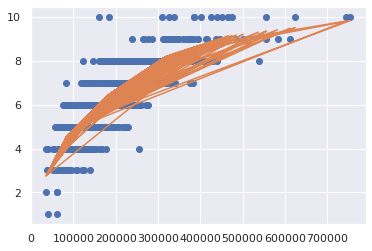

In [71]:
# plot the results
plt.figure()
plt.plot(train['SalePrice'], train['OverallQual'], 'o')
plt.plot(xHat, yHat, '-')
plt.show()

## <h3>Generate predictions and output file</h3>

In [72]:
x = test_features
test_preds = lin_reg.predict(x)

In [73]:
output = pd.DataFrame({'Id': test.Id,
                       'SalePrice': test_preds})
output.to_csv('submission.csv', index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Conclusion

The linear regression model using only a single feature (OverallQual) has a higher R squared and therefore seems to make better predictions than the multiple linear regression model using several correlated features. Part of the issue, I think, with the multiple linear regression presented here is because of the multicollinearity caused by not removing dependent features with a high correlation.